In [ ]:
!pip install imbalanced-learn

In [ ]:
!pip install lightgbm

In [3]:
import pandas as pd
import numpy as np

# Graphical tools
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# For creating a pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline

# For preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier

# Hyperparameter tuning and cross-validation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Classes for dealing with imbalanced datasets
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Extracting scores for all classes
from sklearn.metrics import classification_report, make_scorer, accuracy_score

# Utilities
from scipy.stats import uniform
from scipy.stats import randint
import warnings
from sklearn.exceptions import UndefinedMetricWarning


In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# 0) Understand the dataset

In [164]:
df_train.dtypes

id                           int64
short_name                  object
overall                      int64
potential                    int64
value_eur                  float64
                            ...   
goalkeeping_kicking          int64
goalkeeping_positioning      int64
goalkeeping_reflexes         int64
goalkeeping_speed          float64
position                    object
Length: 70, dtype: object

In [165]:
df_train.shape

(6895, 70)

# 1) Exploratory Data Analysis

In this initial section, we conduct a detailed examination of the dataset's primary characteristics with the following objectives in mind:
1. Get a first grasp of the types of variables that the dataset includes, differentiating between numerical and categorical variables.
2. Check outliers found in the test and training dataset.
3. Check missing values found in the test and training dataset.
4. Examine the correlation between the numerical features, which we use for filtering out some redundant variables.
5. Perform a preliminary analysis of the predictive power of the most abundant variables in this dataset, numerical variables. Based on this analysis, we also filter out variables which are not expected to provide a good discriminatory power between our target, footbal positions.
6. Analyze the predictive power of one of the categorical variables which is expected to provide a high level of discrimination: the preferred foot variable.
7. Lastly, we construct a baseline model, a random forest, which allows us to:
    - Test the classification performance of different positions,
    - Rank the features by their relevance, and
    - Get a benchmark for the development of further models. 

## a. Data types

In [ ]:
# We get a better visualization of the data types of the dataset
def dataframe_dtypes_overview(df):

    """
    Provides an overview of the data types in a DataFrame, including counts and variable names.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    
    Returns:
    None: Prints the data type counts and variable names grouped by type.
    """

    dtype_counts = df.dtypes.value_counts()
    print("Data Type Overview:")
    for dtype, count in dtype_counts.items():
        print(f"\nData type: {dtype} ({count} variables)")
        cols = df.select_dtypes(include=[dtype]).columns
        print("Variables:", ", ".join(cols))

dataframe_dtypes_overview(df_train)

Data Type Overview:

Data type: int64 (46 variables)
Variables: id, overall, potential, wage_eur, height_cm, weight_kg, league_level, club_jersey_number, club_contract_valid_until, weak_foot, skill_moves, international_reputation, attacking_crossing, attacking_finishing, attacking_heading_accuracy, attacking_short_passing, attacking_volleys, skill_dribbling, skill_curve, skill_fk_accuracy, skill_long_passing, skill_ball_control, movement_acceleration, movement_sprint_speed, movement_agility, movement_reactions, movement_balance, power_shot_power, power_jumping, power_stamina, power_strength, power_long_shots, mentality_aggression, mentality_interceptions, mentality_positioning, mentality_vision, mentality_penalties, mentality_composure, defending_marking_awareness, defending_standing_tackle, defending_sliding_tackle, goalkeeping_diving, goalkeeping_handling, goalkeeping_kicking, goalkeeping_positioning, goalkeeping_reflexes

Data type: object (14 variables)
Variables: short_name, birth

Overall, we have 68 features (there are 70 columns in the dataset, excluding `position`, the `target`, and `id`), of which there are:

- 48 purely numerical features.
- 3 variables of type date.
- 4 categorical ordinal features (which are already encoded).
- 13 categorical nominal features. In the data preprocessing step, we will one-hot encode the most relevant variables within this group.

## b. Checking outliers
In this section, we do a basic analysis to get a representative picture of the presence and relevance of outliers in the numerical features of our dataset. Furthermore, we justify our decision for not dropping outliers.

In [ ]:
# We create a function that checks outliers

def check_outliers(dataframe):

    # Dictionary to hold the outliers information
    outliers_dict = {}

    for column in list(dataframe.columns):

        # For now, we ignore null values by dropping all observations with null values
        series_no_na = dataframe[column].dropna()

        # Calculate quartiles 25% and 75%
        q25, q75 = np.quantile(series_no_na, 0.25), np.quantile(series_no_na, 0.75)

        # Calculate the IQR
        iqr = q75 - q25

        # Calculate the outlier cutoff (in this case, set at 1.5 times the IQR)
        cut_off = iqr * 1.5

        # Calculate the lower and upper bound value
        lower, upper = q25 - cut_off, q75 + cut_off

        # Find the outliers
        outliers = [x for x in series_no_na if (x >= upper) or (x <= lower)]

        # Store the information in a dictionary, where each column will have its
        # own dictionary
        outliers_dict[column] = {
            'IQR': iqr,
            'Minimum': series_no_na.min(),
            'Lower Bound': lower,
            'Median': series_no_na.median(),
            'Upper Bound': upper,
            'Maximum': series_no_na.max(),
            'Outliers': outliers,
            'Num Outliers': len(outliers),
            'Num Observations': series_no_na.shape[0],
            'Percentage Outliers': (len(outliers) * 100)/series_no_na.shape[0]
        }

        # We convert the dictionary into a pandas DataFrame
        df_outliers = pd.DataFrame(outliers_dict)

    return df_outliers

In [ ]:
# List of numerical features (48 in total), that will be used for checking outliers below
numerical_features = [
    'overall', 'potential', 'wage_eur', 'height_cm', 'weight_kg',
    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
    'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
    'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance',
    'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
    'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
    'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle',
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes',
    'goalkeeping_speed', 'value_eur', 'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 
    'physic'
]

### i. Training dataset

In [ ]:
outliers_train = check_outliers(df_train[numerical_features])
outliers_train

,overall,potential,wage_eur,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,...,goalkeeping_reflexes,goalkeeping_speed,value_eur,release_clause_eur,pace,shooting,passing,dribbling,defending,physic
IQR,7.0,8.0,10000.0,9.0,10.0,23.0,31.0,19.0,12.0,28.0,...,6.0,14.0,2175000.0,4300000.0,15.0,22.0,13.0,12.0,24.0,11.0
Minimum,49,53,500,156,53,7,2,5,7,4,...,2,15.0,25000.0,39000.0,28.0,18.0,25.0,29.0,16.0,31.0
Lower Bound,54.5,56.0,-13000.0,163.5,55.0,8.5,-13.5,19.5,40.0,-11.0,...,-1.0,12.0,-2537500.0,-5350000.0,39.5,10.0,34.5,41.0,7.0,46.5
Median,68.0,72.0,4000.0,182.0,75.0,58.0,52.0,58.0,65.0,46.0,...,11.0,41.0,1400000.0,2300000.0,70.0,57.0,60.0,65.0,61.0,69.0
Upper Bound,82.5,88.0,27000.0,199.5,95.0,100.5,110.5,95.5,88.0,101.0,...,23.0,68.0,6162500.0,11850000.0,99.5,98.0,86.5,89.0,103.0,90.5
Maximum,93,95,350000,203,103,94,95,93,94,90,...,90,65.0,194000000.0,373500000.0,97.0,94.0,93.0,95.0,89.0,90.0
Outliers,"[83, 54, 85, 85, 85, 87, 83, 86, 88, 84, 83, 5...","[88, 55, 88, 55, 55, 56, 88, 88, 88, 56, 55, 9...","[105000, 31000, 27000, 31000, 38000, 46000, 28...","[163, 163, 160, 162, 163, 160, 203, 163, 156, ...","[95, 95, 95, 99, 98, 95, 53, 103, 95, 95, 96, ...","[8, 7, 8, 8, 7, 8, 8, 8, 8]",[],"[14, 10, 11, 14, 10, 14, 11, 11, 19, 13, 18, 1...","[30, 39, 32, 27, 33, 28, 33, 34, 32, 20, 31, 3...",[],...,"[78, 84, 81, 68, 65, 73, 63, 60, 69, 62, 79, 7...",[],"[6500000.0, 30000000.0, 13000000.0, 7500000.0,...","[12200000.0, 57800000.0, 24400000.0, 12500000....","[35.0, 39.0, 31.0, 37.0, 32.0, 31.0, 38.0, 33....",[],"[34.0, 91.0, 91.0, 93.0, 34.0, 29.0, 34.0, 34....","[36.0, 38.0, 34.0, 41.0, 38.0, 41.0, 38.0, 38....",[],"[43.0, 46.0, 43.0, 46.0, 39.0, 45.0, 42.0, 41...."
Num Outliers,178,92,767,36,39,9,0,560,609,0,...,635,0,927,878,141,0,28,114,0,94
Num Observations,6895,6895,6895,6895,6895,6895,6895,6895,6895,6895,...,6895,631,6893,6542,6264,6264,6264,6264,6264,6264
Percentage Outliers,2.581581,1.3343,11.124003,0.522117,0.565627,0.130529,0.0,8.121827,8.832487,0.0,...,9.209572,0.0,13.448426,13.420972,2.250958,0.0,0.446999,1.819923,0.0,1.500639


### ii. Test dataset

In [ ]:
outliers_test = check_outliers(df_test[numerical_features])
outliers_test

,overall,potential,wage_eur,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,...,goalkeeping_reflexes,goalkeeping_speed,value_eur,release_clause_eur,pace,shooting,passing,dribbling,defending,physic
IQR,8.0,8.0,11000.0,10.5,9.0,25.0,30.0,17.0,11.0,27.0,...,6.0,12.75,2350000.0,4850000.0,14.0,21.0,13.0,11.0,22.0,11.0
Minimum,48,55,500,163,54,7,6,8,14,5,...,3,19.0,80000.0,100000.0,30.0,20.0,35.0,35.0,19.0,39.0
Lower Bound,53.0,56.0,-14500.0,160.75,57.5,3.5,-11.0,23.5,42.5,-9.5,...,-1.0,17.125,-2750000.0,-5975000.0,42.0,12.5,34.5,43.5,12.0,47.5
Median,69.0,72.0,5000.0,182.0,75.0,58.0,52.0,58.0,65.0,46.0,...,11.0,42.0,1500000.0,2600000.0,70.0,56.0,61.0,65.0,62.0,69.0
Upper Bound,85.0,88.0,29500.0,202.75,93.5,103.5,109.0,91.5,86.5,98.5,...,23.0,68.125,6650000.0,13425000.0,98.0,96.5,86.5,87.5,100.0,91.5
Maximum,89,91,230000,201,100,88,89,87,89,85,...,88,64.0,94000000.0,187000000.0,93.0,85.0,86.0,87.0,91.0,87.0
Outliers,"[53, 52, 48, 89, 85, 86, 87, 85, 89]","[89, 88, 89, 55, 89, 90, 89, 90, 56, 91]","[32000, 39000, 30000, 45000, 52000, 44000, 430...",[],"[98, 54, 100, 95, 100, 95, 94, 98, 95]",[],[],"[15, 11, 13, 17, 16, 14, 14, 12, 13, 9, 13, 14...","[25, 28, 33, 31, 28, 18, 22, 29, 36, 37, 30, 2...",[],...,"[74, 56, 83, 72, 72, 81, 58, 76, 82, 74, 77, 8...",[],"[12500000.0, 18500000.0, 18000000.0, 9500000.0...","[22200000.0, 35200000.0, 35600000.0, 16900000....","[39.0, 32.0, 35.0, 41.0, 42.0, 41.0, 39.0, 31....",[],[],"[43.0, 42.0, 39.0, 42.0, 42.0, 39.0, 41.0, 40....",[],"[46.0, 47.0, 46.0, 43.0, 39.0, 43.0, 45.0, 42...."
Num Outliers,9,10,73,0,9,0,0,69,69,0,...,70,0,103,98,18,0,0,18,0,9
Num Observations,767,767,767,767,767,767,767,767,767,767,...,767,70,764,719,697,697,697,697,697,697
Percentage Outliers,1.173403,1.303781,9.517601,0.0,1.173403,0.0,0.0,8.996089,8.996089,0.0,...,9.126467,0.0,13.481675,13.630042,2.582496,0.0,0.0,2.582496,0.0,1.291248


### iii. Insights
- There are outliers in a majority of the numerical features, but there does not seem to be measurement or input errors.
- Furthermore, there are several features for which there is a very large number of outliers (according to this test), such as `wage_eur` (767 outliers out of 6895 observations), `attacking_heading_accuracy` (560 outliers) or `skill_long_passing` (359 outliers).
- However, **we will not be dropping outliers from the training set nor from the test set**. The reason for this decision is twofold:
    - First, we don't want to reduce significantly the amount of information in the dataset.
    - Second, in the specific domain of football players, we actually think that outliers must be kept, given that there are some extraordinary players with outstanding values in some variables which may help us in predicting the position of other outstanding players. Otherwise, our predictions for these types of players (who, very often, are also specialized in a specific set of skills) won't be accurate.

## c. Checking missing values

### i. Training dataset

In [ ]:
# Count of null values per column
df_train_na = df_train.isnull().sum()

# Filter only columns with missing values
missing_values_tr = df_train_na[df_train_na > 0]

# Compute percentage of missing values
missing_values_train_percentage = (missing_values_tr / len(df_train)) * 100

# Display the result
print("Columns with missing values:")
print(missing_values_tr)
print("\nPercentage of missing values:")
print(missing_values_train_percentage)

Columns with missing values:
value_eur                  2
club_loaned_from        6544
club_joined              351
nation_jersey_number    6482
release_clause_eur       353
player_tags             6124
player_traits           2589
pace                     631
shooting                 631
passing                  631
dribbling                631
defending                631
physic                   631
goalkeeping_speed       6264
dtype: int64

Percentage of missing values:
value_eur                0.029007
club_loaned_from        94.909355
club_joined              5.090645
nation_jersey_number    94.010152
release_clause_eur       5.119652
player_tags             88.817984
player_traits           37.548949
pace                     9.151559
shooting                 9.151559
passing                  9.151559
dribbling                9.151559
defending                9.151559
physic                   9.151559
goalkeeping_speed       90.848441
dtype: float64


### ii. Test dataset

In [ ]:
# Count of null values per column
df_test_na = df_test.isnull().sum()

# Filter only columns with missing values
missing_values_test = df_test_na[df_test_na > 0]

# Compute percentage of missing values
missing_values_test_percentage = (missing_values_test / len(df_test)) * 100

# Display the result
print("Columns with missing values:")
print(missing_values_test)
print("\nPercentage of missing values:")
print(missing_values_test_percentage)

Columns with missing values:
value_eur                 3
club_loaned_from        722
club_joined              45
nation_jersey_number    716
release_clause_eur       48
player_tags             682
player_traits           285
pace                     70
shooting                 70
passing                  70
dribbling                70
defending                70
physic                   70
goalkeeping_speed       697
dtype: int64

Percentage of missing values:
value_eur                0.391134
club_loaned_from        94.132986
club_joined              5.867014
nation_jersey_number    93.350717
release_clause_eur       6.258149
player_tags             88.917862
player_traits           37.157757
pace                     9.126467
shooting                 9.126467
passing                  9.126467
dribbling                9.126467
defending                9.126467
physic                   9.126467
goalkeeping_speed       90.873533
dtype: float64


### iii. Insights

The distribution of missing values between the training and the test dataset is very similar. Furthermore, there are no concerning missing values since they are all related to the domain of the sample:
- **value_eur**: Missing for players who are new or not yet assessed in the transfer market.
- **nation_jersey_number**: These players haven't been selected to play for their national teams.
- **release_clause_eur**: Missing for players without a release clause in their contracts.
- **pace, shooting, passing, dribbling, defending, physic**: Missing for goalkeepers as these attributes are not relevant to their roles. We can exploit this fact to perfectly predict the position for goalkeepers and to remove unnecessary noise when training the models with non-goalkeeping positions. Also, it can be observed that the proportion of missing values for this features is almost identical across the training and test datasets (which means that we have a similar fraction of observations who are goalkeepers in both datasets).
- **goalkeeping_speed**: Missing for non-goalkeepers since this attribute applies only to goalkeepers.

Overall, the missing values that are found in the datasets are not an issue for our purpose (predict football positions), given that the variables which have missing values are either not especially relevant (as will be justified throughout this notebook) or can be exploited for improving the prediction.

## d. Correlation (multicollinearity)
In this section, we explore the correlation between the numerical variables with the purpose of assessing which features contain similar information (and thus, similar predictive power) and, thus, can be excluded from our models.

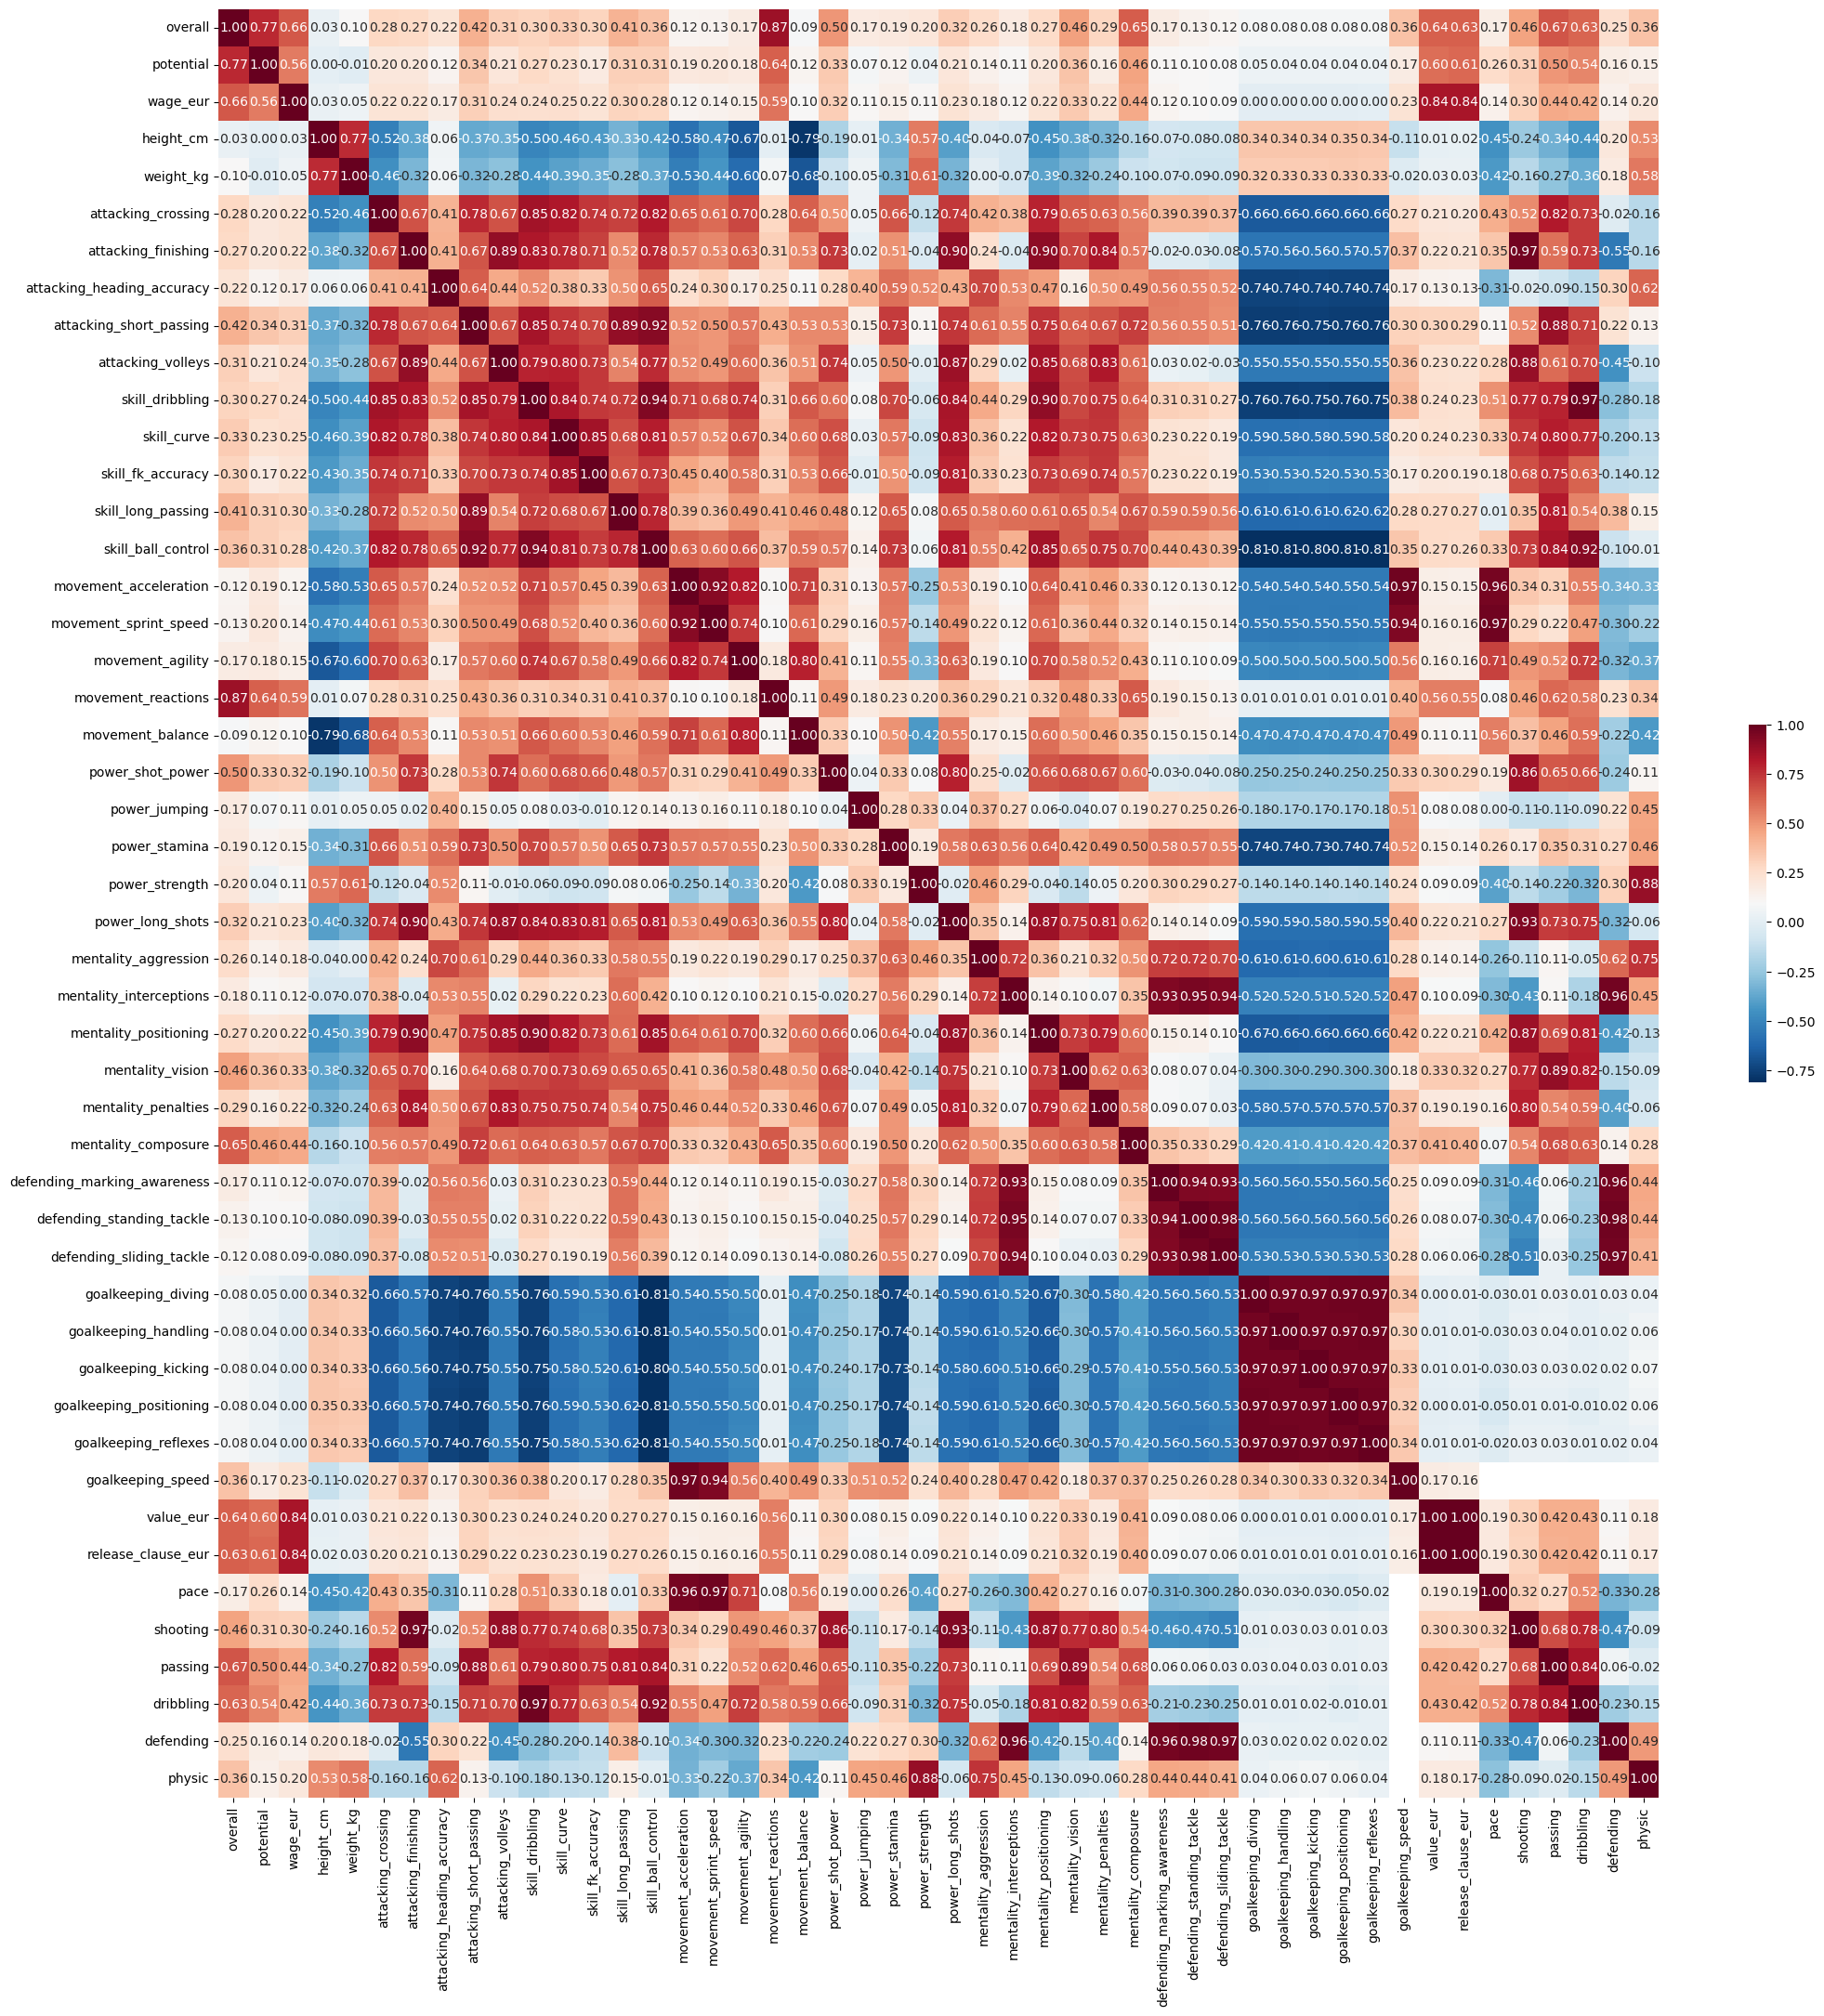

In [ ]:
# We create the correlation matrix
correlation_matrix = df_train[numerical_features].corr()

plt.figure(figsize = (25, 25))
sns.heatmap(correlation_matrix, 
            annot=True,  # Annotate with correlation values
            fmt=".2f",  # Format numbers to 2 decimal places
            cmap='RdBu_r', # Color legend
            cbar_kws={'shrink': 0.2})  # Adjust color bar size
plt.show()

In [ ]:
# Here we check, numerically, those highly correlated variables (linear correlation > |0.9|)

# Initialize a dictionary to store the results
high_corr_dict = {}

# Iterate through the correlation matrix
for i in range(len(correlation_matrix.columns)):
    # We save the name of the feature in each loop
    feature = correlation_matrix.columns[i]
    # List to store highly correlated variables for this feature
    high_corr_vars = []
    
    for j in range(i):  # Check only the lower triangle to avoid duplicates
        if abs(correlation_matrix.iloc[i, j]) > 0.9:  # Threshold for high correlation
            correlated_feature = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]
            
            # Add the correlated feature to the list for the current feature
            high_corr_vars.append((correlated_feature, correlation_value))
    
    # If any highly correlated variables were found, add to the dictionary
    if high_corr_vars:
        high_corr_dict[feature] = {
            "count": len(high_corr_vars),  # Number of highly correlated variables
            "correlated_features": high_corr_vars  # List of (feature, correlation value) tuples
        }

# Display the results in a readable format
for feature, details in high_corr_dict.items():
    print(f"Feature: {feature}")
    print(f"  Count of highly correlated variables: {details['count']}")
    print(f"  Correlated variables and their values: {details['correlated_features']}")
    print("-" * 40)

Feature: skill_ball_control
  Count of highly correlated variables: 2
  Correlated variables and their values: [('attacking_short_passing', 0.9215486365787414), ('skill_dribbling', 0.9361883029698654)]
----------------------------------------
Feature: movement_sprint_speed
  Count of highly correlated variables: 1
  Correlated variables and their values: [('movement_acceleration', 0.9155420444576166)]
----------------------------------------
Feature: mentality_positioning
  Count of highly correlated variables: 1
  Correlated variables and their values: [('attacking_finishing', 0.9014220679403923)]
----------------------------------------
Feature: defending_marking_awareness
  Count of highly correlated variables: 1
  Correlated variables and their values: [('mentality_interceptions', 0.9308726315708117)]
----------------------------------------
Feature: defending_standing_tackle
  Count of highly correlated variables: 2
  Correlated variables and their values: [('mentality_interceptio

Altogether, with this graphical and numerical analysis of the correlation between numerical variables, we extract the following **insights**:
- There are 16 numerical features out of a total of 48 which are highly correlated with other variables.
- Attacking and skill variables (except *attacking_heading_accuracy*) are, overall, highly correlated between them. This means that, potentially, some of these variables could be dropped as they may not add much predictive power. 
- Goalkeeping variables are extremely highly correlated with each other (0.97). So it is safe to drop one and keep the one with the most predictive power for the goalkeeper position. Also, they go their own way in the sense that they are negatively correlated with other variables more related to other positions (attacking, skill, movement, power, etc.).
- *power_long_shots* highly correlated with some attacking variables.
- In general, groups of variables are highly correlated with each other (attacking, defending, skill, mentality), which means that the granularity of these variables may not be needed for improving the prediction of a player's position.
- Overall, this information provides a valuable decision criterion for excluding some features that may not add an additional predictive power.

## e. Boxplots of numerical variables - position (preliminary analysis of predictive power)

In this section, we show boxplots for some numerical variables categorized by the position, in order to get some proof of which variables may not have a significant predictive power and, thus, can be filtered out for the model training.

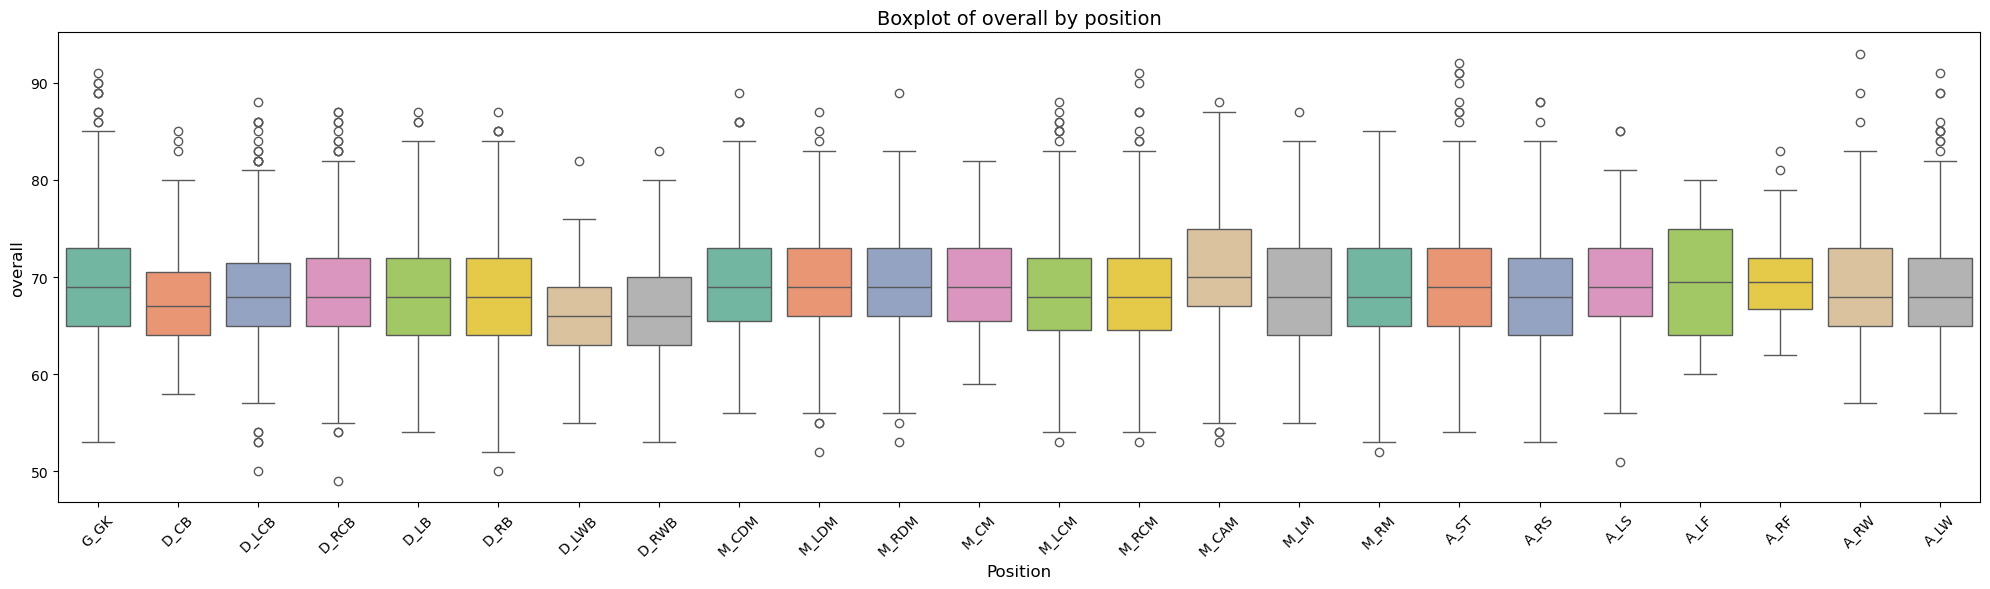

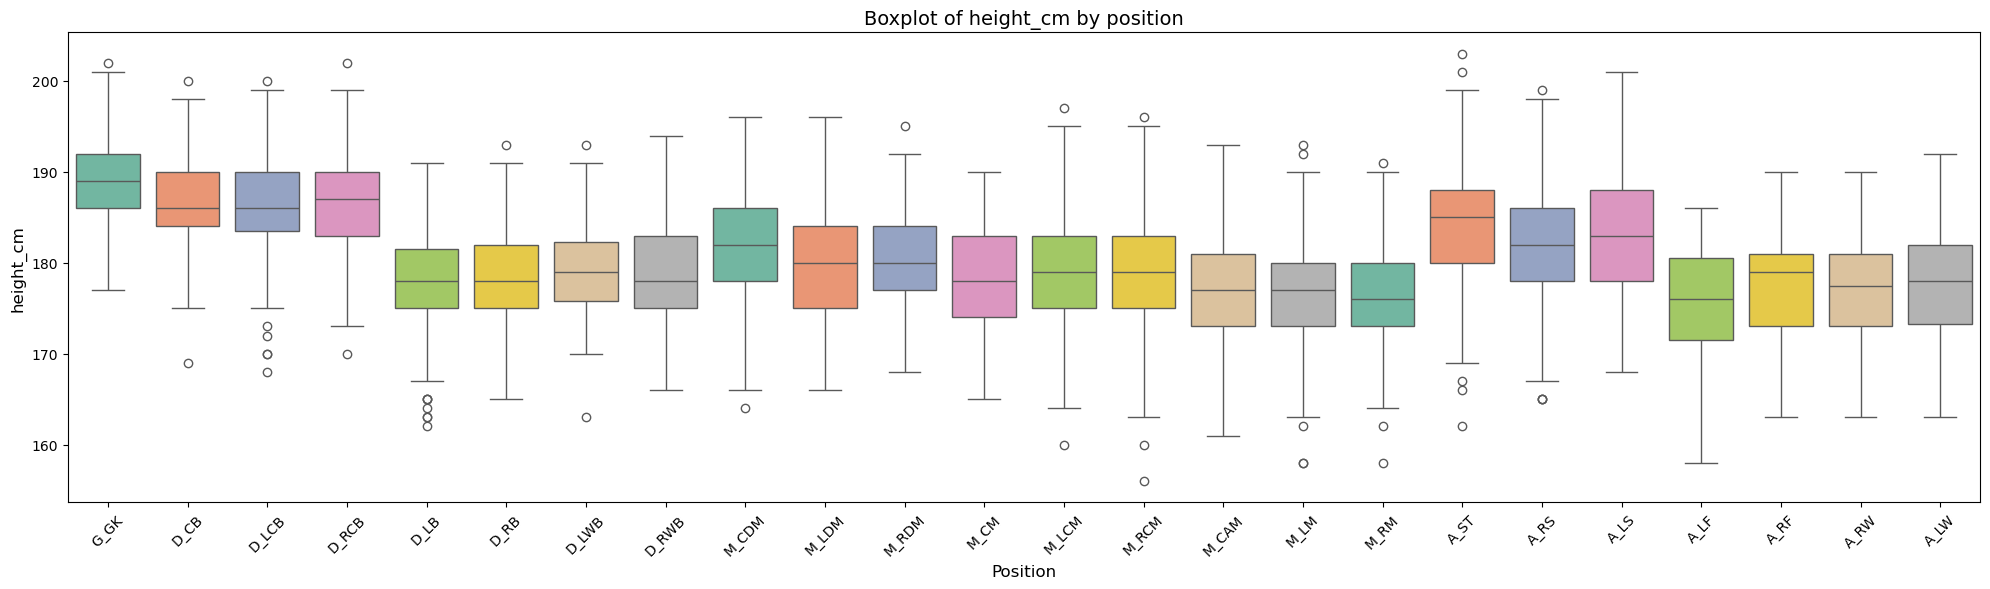

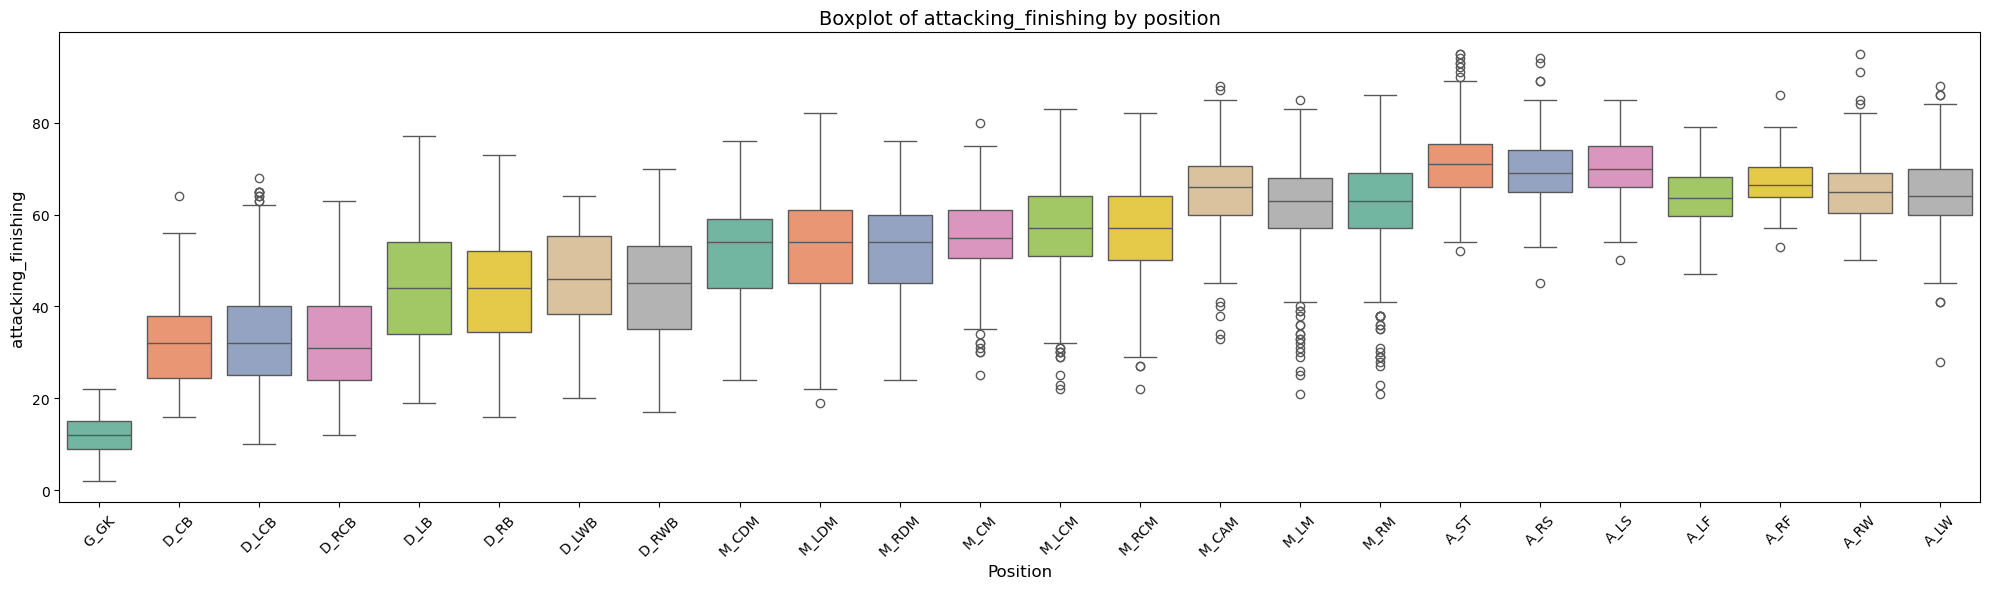

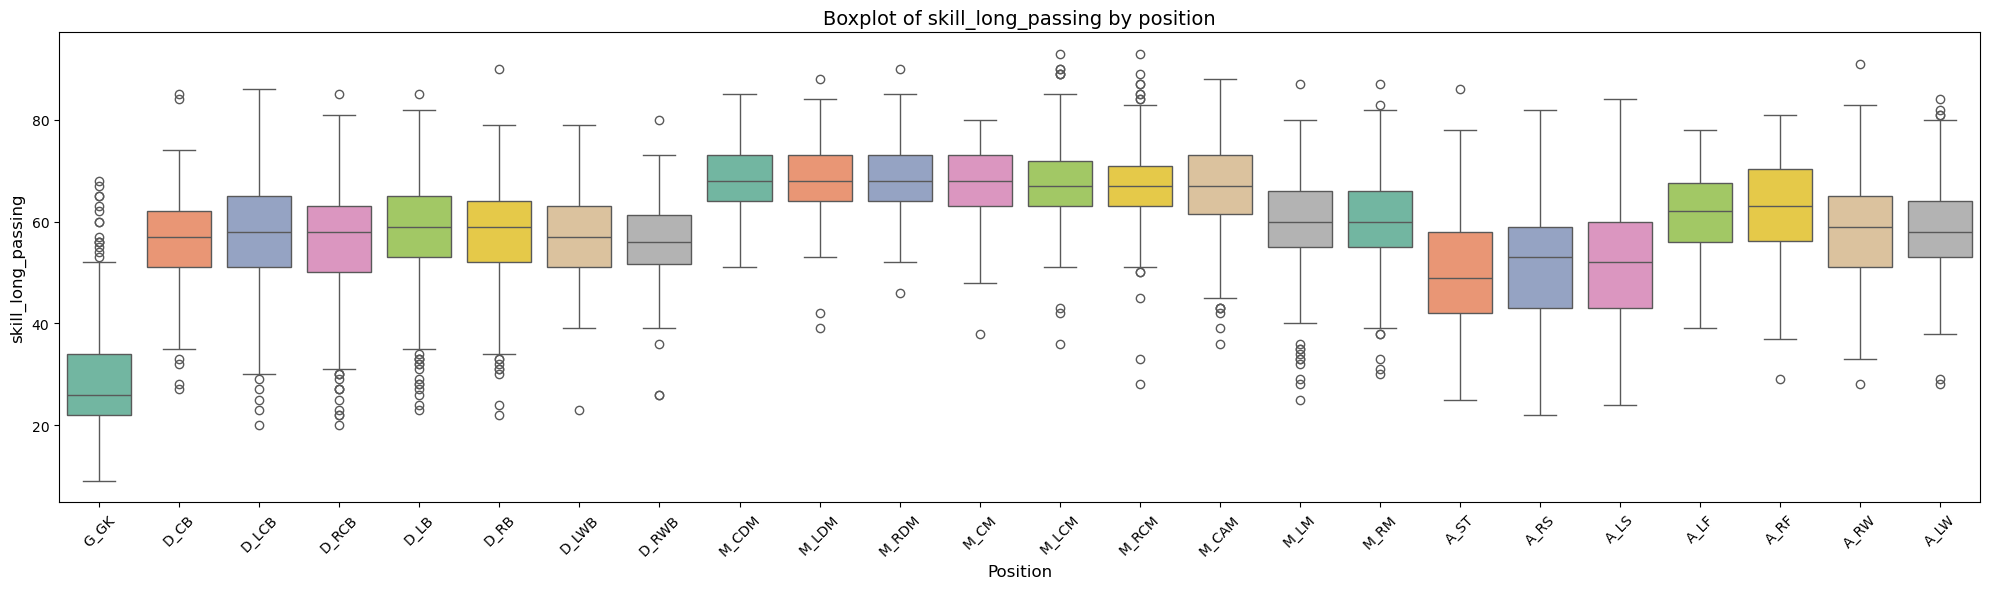

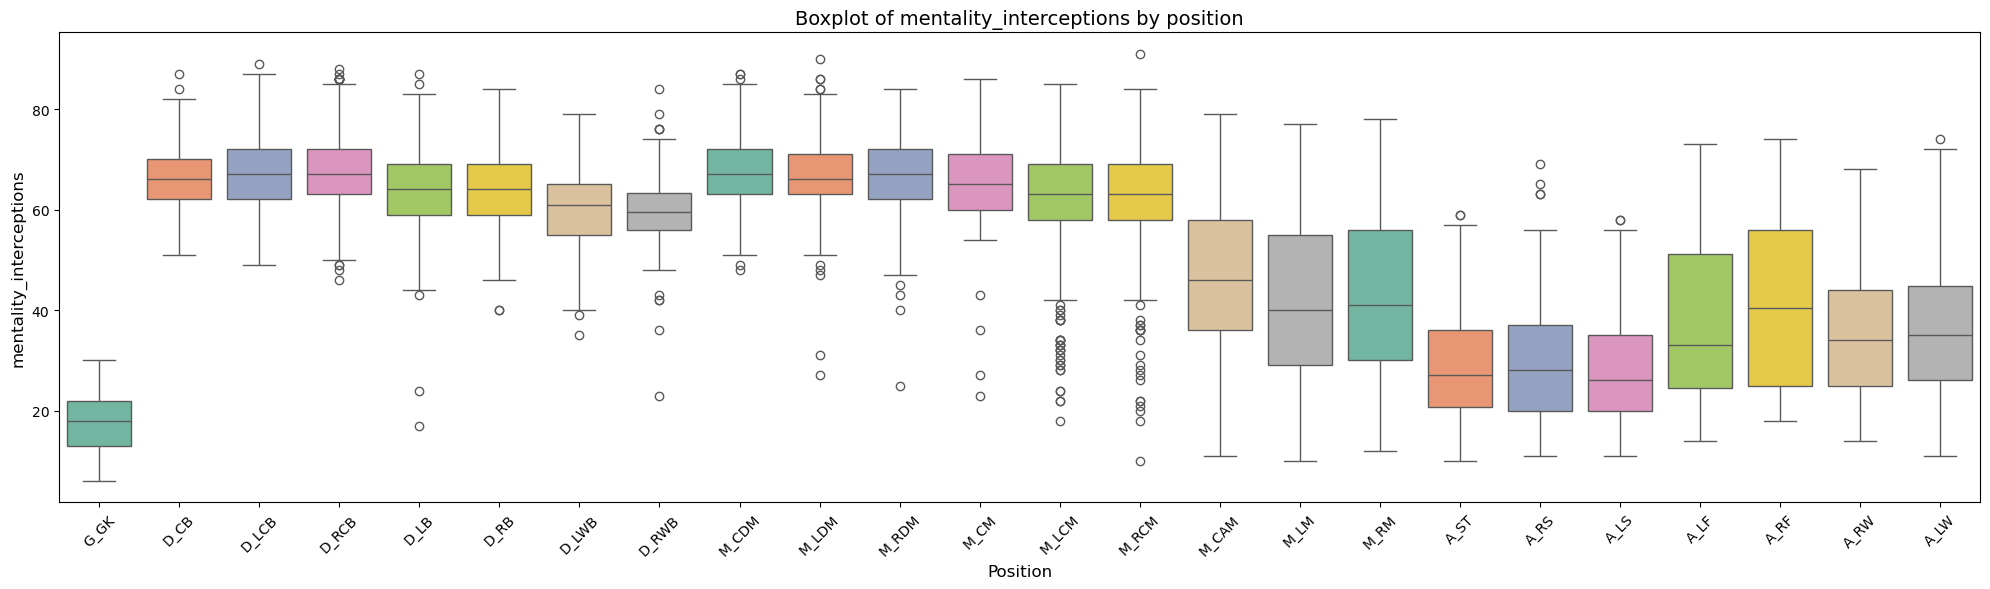

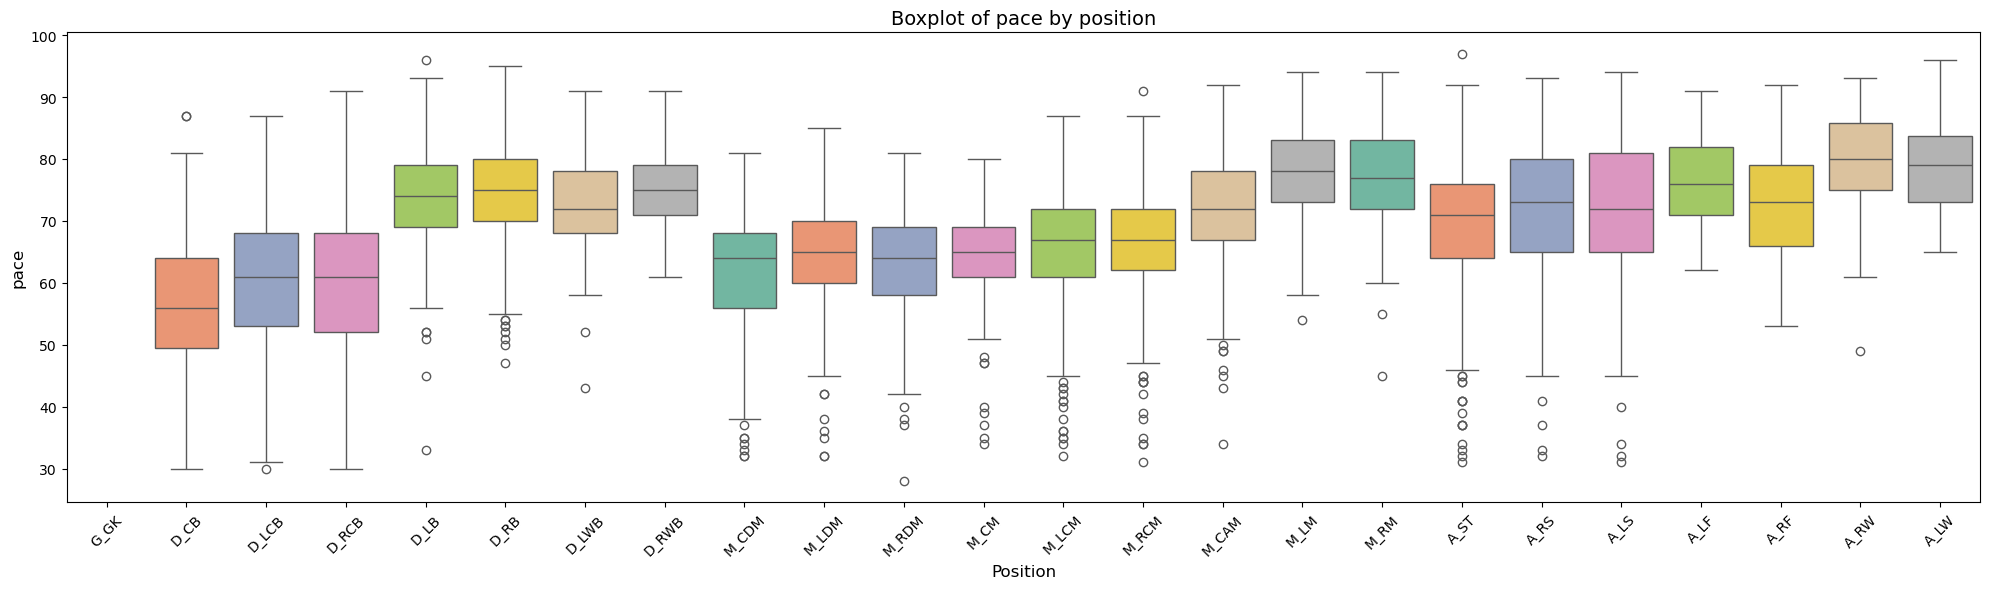

In [ ]:
# First, we reorder the dataframe and assign some prefixes to the positions
# so that it is easier to catch specific patterns

# Mapping positions to their groups
group_mapping = {
    'Goalkeeper': ['GK'],
    'Defenders': ['CB', 'LCB', 'RCB', 'LB', 'RB', 'LWB', 'RWB'],
    'Midfielders': ['CDM', 'LDM', 'RDM', 'CM', 'LCM', 'RCM', 'CAM', 'LM', 'RM'],
    'Attackers': ['ST', 'RS', 'LS', 'LF', 'RF', 'RW', 'LW']
}

# Prefix mappings
prefix_mapping = {
    'Goalkeeper': 'G_',
    'Defenders': 'D_',
    'Midfielders': 'M_',
    'Attackers': 'A_'
}

# Flatten mapping to find the group for each position
position_to_group = {pos: group for group, positions in group_mapping.items() for pos in positions}

# Adding a prefix to position names
df_train['position_grouped'] = df_train['position'].map(lambda x: prefix_mapping[position_to_group[x]] + x)

# Reordering positions based on group
order = [prefix_mapping[group] + pos for group in group_mapping for pos in group_mapping[group]]

# Ordering the data frame by the position categories, so that it is easier to 
# catch patterns in the boxplots
df_train['position_grouped'] = pd.Categorical(df_train['position_grouped'], categories=order, ordered=True)

for feature in ['overall', 'height_cm', 'attacking_finishing', 'skill_long_passing',
               'mentality_interceptions', 'pace']:
    plt.figure(figsize=(20, 6))  # Adjust the figure size as needed
    sns.boxplot(data = df_train, x='position_grouped', y=feature, hue = 'position_grouped', palette="Set2", legend=False)
    plt.title(f'Boxplot of {feature} by position', fontsize=14)
    plt.xlabel('Position', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.tight_layout()
    plt.show()

From the selection of boxplots shown above, we can observe some **relevant patterns that the dataset displays regarding the predictive power of different features**:
- `overall`: we can observe that the distribution is not significantly different across different positions. This means that we don't expect this feature to provide enough variability to discriminate among different positions. The variable *potential*, which is highly correlated with the *overall* feature, exhibits a similar predictive power.
- `height` has a potentially high predictive power. There is significant variability in the distributions for different positions. Specifically, we observe that the distribution of height of the positions CB, LCB and RCB (central defenders), as well as ST, LS and RS (strickers) is higher than for the other positions. Therefore, we expect that this variable proves useful in differentiating between these positions and the other ones. The feature *weight*, which has not been included here, exhibits similar variability.
- `attacking_finishing`: we observe that positions that are deeper in the opponent's field have a higher distribution for this feature than positions more focused on defending. There are approximately 4 clusters of positions based  on this variable (excluding the goalkeeping variable), namely central defenders, side defenders, midfielders that are positioned more to the back and then midfielders and attackers with the highest distributions based on this variable. Consequently, we expect a good discriminatory power based on this variable. Other attacking variables exhibit a similar variabiility across positions (with some differences, but for conciseness reasons they are not shown here).
- `skill_long_passing`: in this case, we observe greater values (overall) for midfielders than for the other positions, with also significant variability across some positions in the midfield and across the attacking positions.
- `mentality_interceptions`: this feature exhibits very significant variability between defenders and some midfielders and the rest of the midfielders together with the attackers. A downside of this variable is that it does not show relevant variability within the defenders group, so it is not expected to provide a good discriminatory power to be able to distinguish between different types of defenders.
- `pace`: this feature shows discriminatory power across some defener positions, across some midfielder positions and also (to a minor extent) across attacking positions. Thus, it can help us distinguish between some positions within these groups. Other features, such as *movement_acceleration*, show similar variability (and thus predictive power). 
    - Regarding this variable, we have noted that there are null values for this variable for goalkeepers, so when doing the training and the predictions we have separated the predictions for goalkeepers and non-goalkeepers based on this fact, so that we also remove the noise that may be introduced by including goalkeepers in the prediction of the other positions.
    - In section 2, of data preprocessing, we further justify this observation by using another variable that exhibits the same property (but with missing values for non-goalkeeper positions), `goalkeeping_speed`.

Altogether, we have made this analysis for each numerical variable in the dataset. **We have used the insights obtained from this preliminary filter to rule out some variables which do not show significant variability among the different positions, so that the model complexity is reduced and its interpretability is increased**.

## f. Categorical variables
In this section, we limit our analysis to the predictive power to one of the categorical variables which we expect to be more useful for distinguishing among the positions within the same group: the preferred foot of a football player. The idea of this section is to check the relative frequency of a categorical variable depending on the different available positions, while considering the potential class imbalancing. If, for instance, there are different proportions for the possible *preferred_foot* values and the position (which is expected especially for positions on the side), then that means that this categorical variable may be a good predictor.

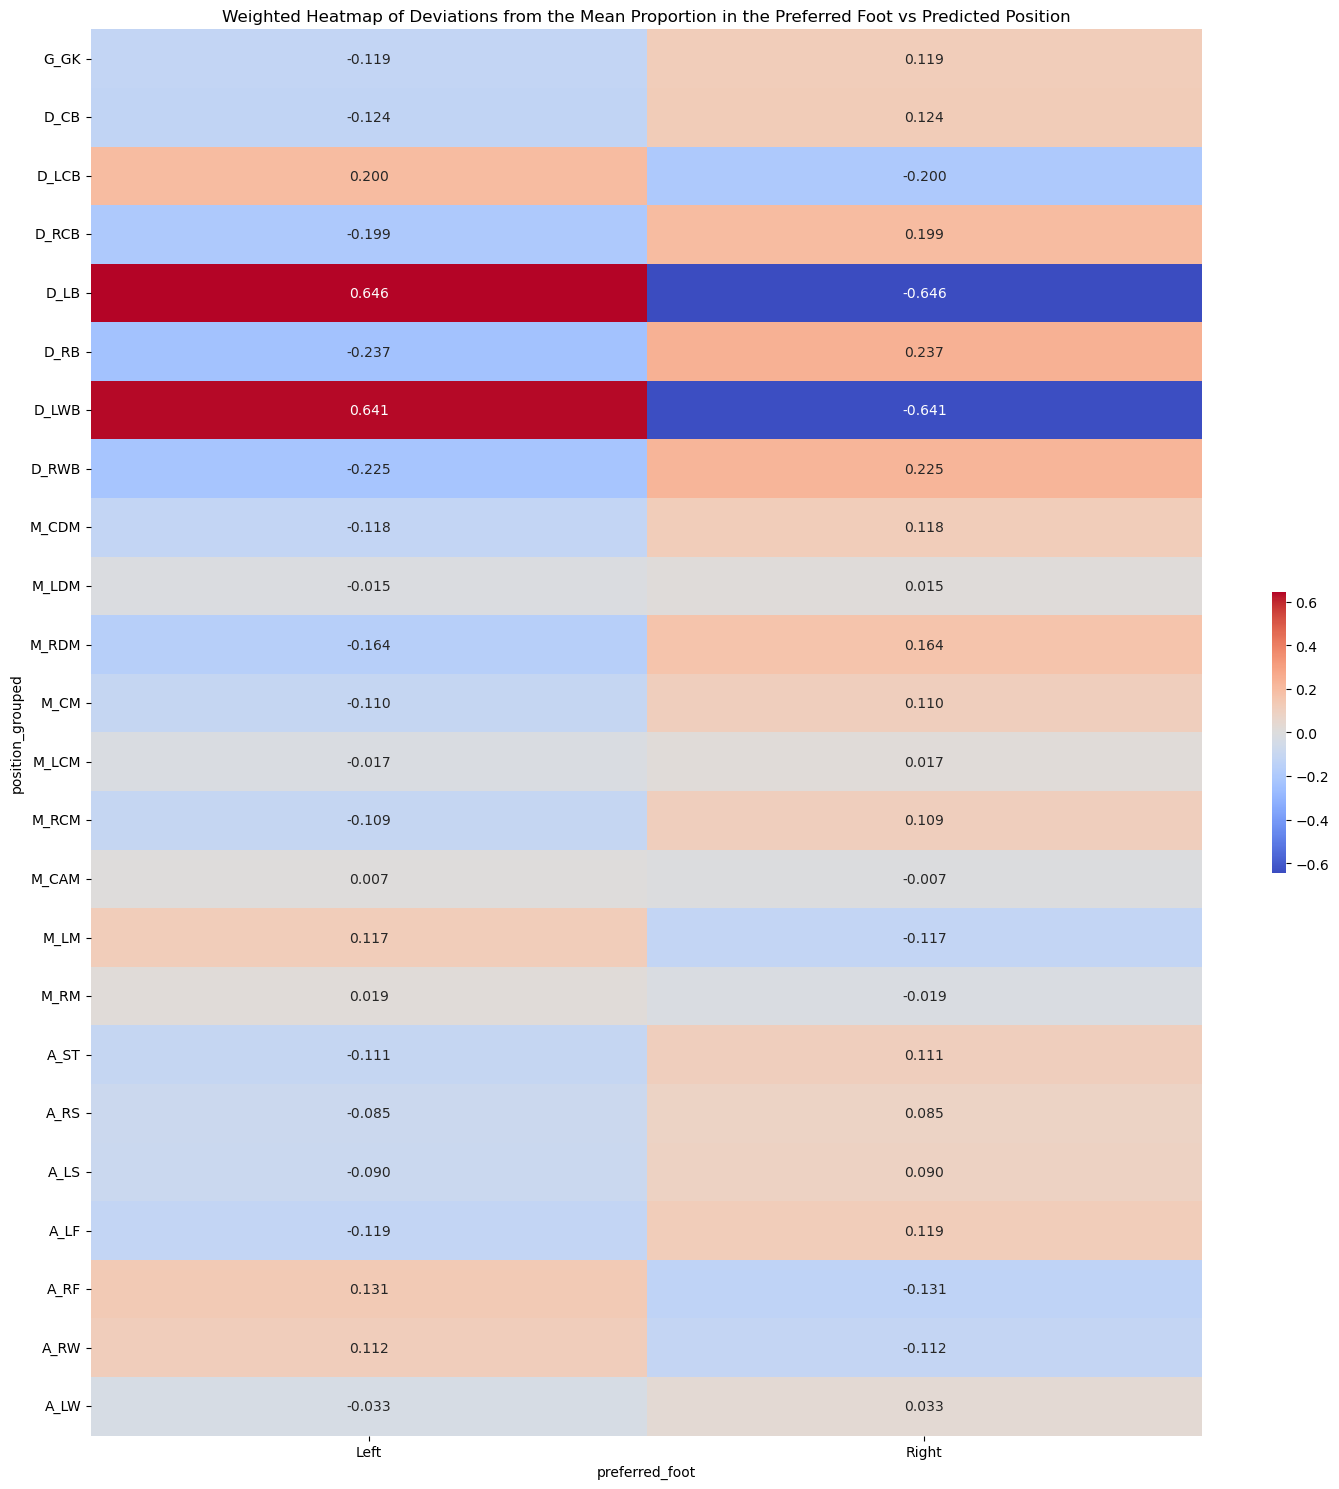

In [ ]:
# We specify the 'index' argument so that the relative frequencies are computed
# over rows, i.e., over the positions (so that each row adds to 1 - thus
# also the fact that the dataset is imbalanced does not affect the results)
foot_pos = pd.crosstab(df_train['position_grouped'], df_train['preferred_foot'], normalize = 'index')

# Calculate differences relative to the mean of the overall relative frequences of preferred foot
# - darkest values will be those with largest differences with respect to the mean
foot_pos_diff = foot_pos - foot_pos.mean()

plt.figure(figsize=(15, 15))
sns.heatmap(foot_pos_diff, 
            annot=True, 
            fmt=".3f", 
            cmap='coolwarm', 
            cbar_kws={'shrink': 0.2}, 
            center=0)  # Center on zero for deviations

plt.title(f"Weighted Heatmap of Deviations from the Mean Proportion in the Preferred Foot vs Predicted Position")
plt.tight_layout()
plt.show()

# We drop the newly created column 'position_grouped'
df_train.drop(columns = ['position_grouped'], inplace = True) 

**Relevant insights**:
- First of all, note that the color intensity of the heatmap is determined in terms of the deviation from the mean proportion for each foot for each position. We can observe, for instance, that there is a high contrast for the deviations in the positions that are on the sides.
- Considering that larger deviations represent larger differences to the mean proportion of relative frequencies for one foot or the other, we can see that positions that are on the sides have greater deviations than center positions. In the case of the left-side defenders (LB and LWB), we observe that there is a significant positive deviation from the median proportion for this position, which means that there is a significant amount of players in this position who have the left foot as their preferred one. Furthermore, we can also observe that attackers on the right have a higher preference for the left foot than for the right, compared to other positions. A similar interpretation can be made for other side positions. 
- These observations match our expectations given the structure of the game and the role of the different positions.

## g. Initial Exploration with Random Forest

Random Forest is a quick and robust classifier to test initial performance, enabling the ranking of features and test classification performance with minimal preprocessing.

In [7]:
# Split the train dataset into features (X) and target (y)
X = df_train.drop(columns=['position'])
y = df_train['position']

# Train a Random Forest Classifier on the full training set
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_clf.fit(X, y)

# Generate predictions for the training set
y_pred = rf_clf.predict(X)

# Create a clean classification report
report_dict = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(2)

# Print only the classification report
print("\nClassification Report (Training Set):\n")
print(report_df.iloc[:-3].to_string(index=True)) 


Classification Report (Training Set):

     precision  recall  f1-score  support
CAM       0.75    0.61      0.67    263.0
CB        1.00    0.13      0.22    167.0
CDM       1.00    0.30      0.46    151.0
CM        1.00    0.01      0.03     75.0
GK        1.00    1.00      1.00    631.0
LB        0.69    0.89      0.78    463.0
LCB       0.85    0.73      0.78    631.0
LCM       0.62    0.79      0.70    423.0
LDM       1.00    0.28      0.44    201.0
LF        1.00    0.06      0.12     32.0
LM        0.72    0.75      0.73    369.0
LS        0.99    0.40      0.57    201.0
LW        1.00    0.29      0.45    166.0
LWB       1.00    0.10      0.18    104.0
RB        0.61    0.93      0.74    463.0
RCB       0.64    0.91      0.75    631.0
RCM       0.49    0.83      0.62    423.0
RDM       0.97    0.34      0.50    201.0
RF        1.00    0.06      0.12     32.0
RM        0.58    0.76      0.66    369.0
RS        1.00    0.46      0.63    201.0
RW        1.00    0.49      0.66    

### Output:

1. **Classification Performance**:
   - The classification report shows the model performs exceptionally well for **GK** (1.00 across all metrics) and reasonably well for positions like **ST** (F1-score: 0.76), **LB** (F1-score: 0.78), **RCB** (F1-score: 0.76), and **RB** (F1-score: 0.75).
   - However, positions like **CM** (F1-score: 0.03), **LF** (F1-score: 0.12), and **LWB** (F1-score: 0.18) perform poorly, indicating difficulty in distinguishing these roles due to their lower representation in the dataset.

2. **Support**:
   - The **support** column highlights class imbalance, with positions like **GK** (631 samples) and **LCB** (631 samples) being overrepresented.
   - Positions like **LF** (32 samples) and **RF** (32 samples) are heavily underrepresented, leading to poor generalization and prediction accuracy for these roles.

3. **Insights on Class Imbalance**:
   - The imbalance skews the model to perform better on overrepresented positions while struggling with rarer ones, as seen in the low recall for classes like **LF** and **CM**.
   - This suggests the need for sampling techniques (e.g., SMOTE, class weighting) to improve performance on underrepresented classes.

In [ ]:
# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display only the top 5 features cleanly
print("\nTop Features:\n")
print(feature_importances.head(5).to_string(index=False))


Top Features:

             Feature  Importance
preferred_foot_Right    0.054754
           defending    0.048755
  attacking_crossing    0.047077
              physic    0.046156
            shooting    0.040979


We may suspect a tendency to use the preferred_foot as the most important feature due to football usual practices of placing players on the left wing if they are left footed and vice-versa.

# 2) Data Preprocessing

### Preprocessing Section

In this section, we focus on preparing the dataset for further analysis:

1. Drop irrelevant columns based on their expected lack of predictive power for the target variable. This includes columns such as `club_jersey_number` and redundant goalkeeper-specific skills.
2. Transform the remaining categorical variables into dummy variables. 

This streamlined preprocessing ensures that the dataset is clean for subsequent feature engineering and modeling sections.


## a. Irrelevant (or Correlated) Features

Using our domain knowledge, we remove features that are irrelevant to a player's position.

In [6]:
# List of columns to drop
columns_to_drop = [
    'short_name', 'nationality_name','birthday_date', 'club_name', 'league_name', 'league_level', 
    'club_loaned_from', 'club_joined', 'club_jersey_number', 'body_type',
    'club_contract_valid_until', 'international_reputation', 'real_face', 'player_tags', 'player_traits',
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'overall', 'potential'
]

# Dropping the columns from the dataset
df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)

### Justification

- **`club_jersey_number`**:  
  Although players used to wear numbers associated with their positions, this practice has lost its significance over the decades due to modern formations (e.g., transitioning from 5 to 3 defenders at the back). Furthermore, this logic primarily applies to starting players (first eleven), which would limit the model's generalization power.

- **GK's skills (except `goalkeeper_speed`)**:  
  The 'goalkeeper_speed' column only contains values for GK in the training dataset. As shown below, the test dataset displays a similar distribution of non-null values in the column. This consistency suggests a strict data generation policy, where non-GK players are assigned null values in this column.


In [ ]:
# Calculate frequency of non-null values in goalkeeping_speed
train_gk_speed_frequency = df_train['goalkeeping_speed'].notnull().mean()
test_gk_speed_frequency = df_test['goalkeeping_speed'].notnull().mean()

# Print results
print(f"Frequency of non-null 'goalkeeping_speed' in train dataset: {train_gk_speed_frequency:.2%}")
print(f"Frequency of non-null 'goalkeeping_speed' in test dataset: {test_gk_speed_frequency:.2%}")

Frequency of non-null 'goalkeeping_speed' in train dataset: 9.15%
Frequency of non-null 'goalkeeping_speed' in test dataset: 9.13%


## b. Dummies

Converting remaining categorical variables into dummies.

In [ ]:
# Handle categorical variables
df_train = pd.get_dummies(df_train, columns=['preferred_foot', 'work_rate'], drop_first=False)
df_test = pd.get_dummies(df_test, columns=['preferred_foot', 'work_rate'], drop_first=False)

# 3) Cross-Validation Strategy (Testing Balance Techniques)

Implement robust cross-validation techniques to mitigate overfitting and optimize model generalization performance.

## a. Visualize Class Imbalance

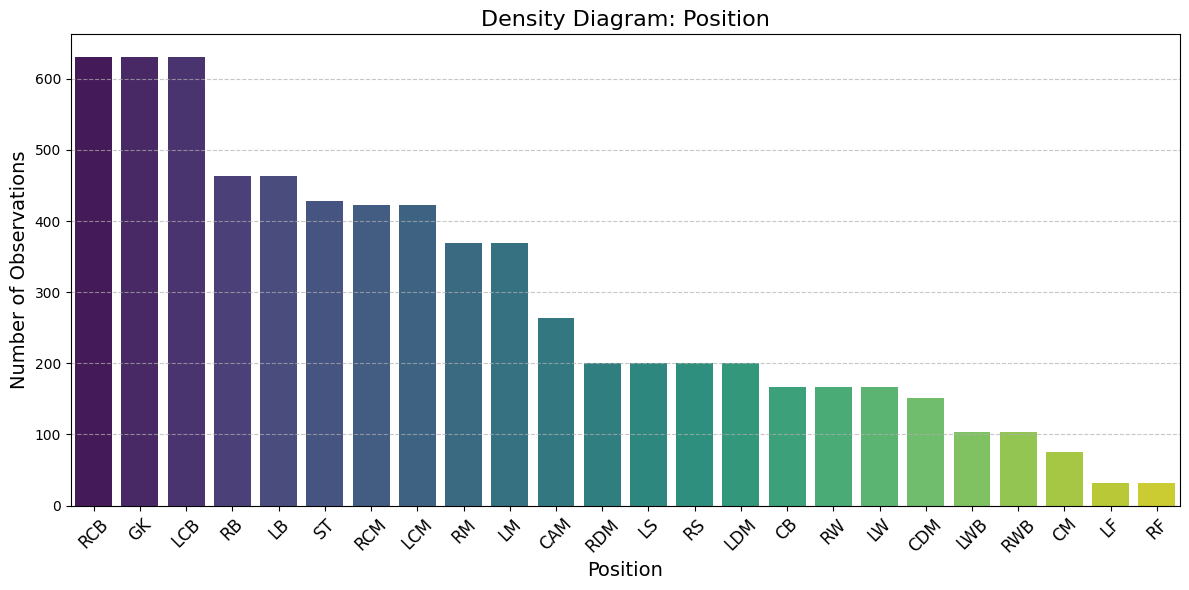

In [ ]:
# Count the number of observations for each position
position_counts = df_train['position'].value_counts()

# Create a density diagram
plt.figure(figsize=(12, 6))
sns.barplot(x=position_counts.index, y=position_counts.values, hue=position_counts.index, palette="viridis", legend=False)

# Add plot details
plt.title('Density Diagram: Position', fontsize=16)
plt.xlabel('Position', fontsize=14)
plt.ylabel('Number of Observations', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

The density diagram highlights a significant class imbalance among player positions, specially between [**RCB**, **LCB**,  **GK**] and [**LF**, **RF**]

This imbalance poses a challenge to the model performance, as it might overfit to dominant classes.

Cross-validation is essential to ensure model evaluation across all classes. By splitting the data into multiple folds, we can assess model performance on diverse subsets, including minority classes, mitigating biases introduced by imbalanced data.


## a. K-Fold

Stratified K-Fold ensures each fold has a representative distribution of the target classes, particularly relevant in our case given the low representation of LF and RF.

In [30]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Define the model
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, class_weight='balanced')

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Custom scoring metric
scoring = make_scorer(accuracy_score)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(rf_clf, X, y, cv=skf, scoring=scoring)

# Print cross-validation accuracy scores
print("\nCross-Validation Scores:\n", cv_scores)
print("\nMean Cross-Validation Accuracy:", cv_scores.mean())

# Train and evaluate on each fold for classification report (optional)
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Train on fold
    rf_clf.fit(X_train_fold, y_train_fold)

    # Predict on validation fold
    y_pred_fold = rf_clf.predict(X_val_fold)

    # Classification report for each fold
    print(f"\nClassification Report for Fold {fold}:\n")
    print(classification_report(y_val_fold, y_pred_fold))


Cross-Validation Scores:
 [0.41479333 0.40681653 0.41479333 0.42059463 0.40029007]

Mean Cross-Validation Accuracy: 0.41145757795503995

Classification Report for Fold 1:

              precision    recall  f1-score   support

         CAM       0.25      0.34      0.29        53
          CB       0.23      0.18      0.20        33
         CDM       0.12      0.20      0.15        30
          CM       0.06      0.13      0.08        15
          GK       1.00      1.00      1.00       127
          LB       0.60      0.78      0.68        93
         LCB       0.64      0.44      0.52       126
         LCM       0.43      0.15      0.23        84
         LDM       0.05      0.05      0.05        40
          LF       0.00      0.00      0.00         6
          LM       0.17      0.05      0.08        74
          LS       0.19      0.12      0.15        40
          LW       0.14      0.15      0.15        33
         LWB       0.10      0.10      0.10        21
          RB    

#### Interpretation

With a Mean Cross-Validation Accuracy of ~41.1%, this techniques provided a reliable baseline estimate of the model to compare with future results across multiple models.

## b. Class Weights

We use this technique to balance the representation of underrepresented classes without creating synthetic data to avoid adding noise to the model.

In [11]:
# Define the Random Forest with balanced class weights
rf_clf = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    class_weight='balanced'  # Automatically assigns weights inversely proportional to class frequency
)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Custom scoring metric
scoring = make_scorer(accuracy_score)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(rf_clf, X, y, cv=skf, scoring=scoring)

# Print cross-validation accuracy scores
print("\nCross-Validation Scores with Class Weights:\n", cv_scores)
print("\nMean Cross-Validation Accuracy:", cv_scores.mean())

# Train and evaluate on each fold for classification report
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Train the model with class weights
    rf_clf.fit(X_train_fold, y_train_fold)

    # Predict on validation fold
    y_pred_fold = rf_clf.predict(X_val_fold)

    # Classification report for each fold
    print(f"\nClassification Report for Fold {fold}:\n")
    print(classification_report(y_val_fold, y_pred_fold))


Cross-Validation Scores with Class Weights:
 [0.41479333 0.40681653 0.41479333 0.42059463 0.40029007]

Mean Cross-Validation Accuracy: 0.41145757795503995

Classification Report for Fold 1:

              precision    recall  f1-score   support

         CAM       0.25      0.34      0.29        53
          CB       0.23      0.18      0.20        33
         CDM       0.12      0.20      0.15        30
          CM       0.06      0.13      0.08        15
          GK       1.00      1.00      1.00       127
          LB       0.60      0.78      0.68        93
         LCB       0.64      0.44      0.52       126
         LCM       0.43      0.15      0.23        84
         LDM       0.05      0.05      0.05        40
          LF       0.00      0.00      0.00         6
          LM       0.17      0.05      0.08        74
          LS       0.19      0.12      0.15        40
          LW       0.14      0.15      0.15        33
         LWB       0.10      0.10      0.10        

#### Interpretation:

The mean cross-validation accuracy remains ~41.3%, with classes like LF, RF, LWB, and RW still have poor precision and recall values.

## c. Random Oversampling

In [12]:
# Split features and target
X = df_train.drop(columns=['position'])
y = df_train['position']

# Random oversampling for underrepresented classes
oversampler = RandomOverSampler(random_state=42)
X_balanced, y_balanced = oversampler.fit_resample(X, y)

In [13]:
# Train-test split (stratified to preserve class distribution)
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Train Random Forest
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_clf.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf_clf.predict(X_val)

# Evaluate performance
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nCross-Validation Scores:", cv_scores)
print("\nClassification Report:\n", classification_report(y_val, y_pred))

cv_scores = cross_val_score(rf_clf, X_balanced, y_balanced, cv=5, scoring='accuracy')
print("\nMean Cross-Validation Accuracy:", cv_scores.mean())

Validation Accuracy: 0.7117860680092439

Cross-Validation Scores: [0.41479333 0.40681653 0.41479333 0.42059463 0.40029007]

Classification Report:
               precision    recall  f1-score   support

         CAM       0.55      0.69      0.61       126
          CB       0.79      0.89      0.84       126
         CDM       0.71      0.80      0.75       126
          CM       0.58      0.98      0.73       126
          GK       1.00      1.00      1.00       126
          LB       0.74      0.75      0.74       126
         LCB       0.75      0.38      0.50       127
         LCM       0.57      0.21      0.31       127
         LDM       0.64      0.75      0.69       126
          LF       0.98      1.00      0.99       126
          LM       0.80      0.32      0.46       127
          LS       0.86      0.73      0.79       126
          LW       0.64      0.82      0.72       126
         LWB       0.90      0.94      0.92       126
          RB       0.56      0.65      0.

### Key Improvements:

1. **Mean-Cross Validation Accuracy**: Increased to **72.9%**, a substantial improvement from earlier results (~41-3%), demonstrating the effectiveness of random oversampling in balancing the dataset.

2. **Underrepresented Classes**: Classes like **LF** and **RF** achieved near-perfect performance:
   - **LF**: Precision: 0.98, Recall: 1.00, F1-score: 0.99.
   - **RF**: Precision: 0.98, Recall: 1.00, F1-score: 0.99.

3. **Overall Class Performance**:
   - Many previously struggling classes (e.g., **LW**, **RS**, **RWB**) now show significantly improved metrics, with F1-scores exceeding **0.70** for several roles.

### Remaining Challenges:
- **Specific Classes**:
  - Classes like **LM** (F1-score: 0.46) and **RCM** (F1-score: 0.42) still have low performance metrics.
  - This suggests overlapping features and insufficient differentiation for nuanced midfield roles.

# 4) Feature Engineering
In this section, we use our knowledge in the football domain as well as the knowledge acquired through the EDA to create some features that may add significant predictive power. To that end, we create 3 different types of features:
1. First, features for enhancing the prediction for midfielder roles.
2. Second, features for being able to distinguish better between positions in the center and positions on the sides.
3. Third, we create another feature which substitutes the `body_type`variable (which has been removed in preprocessing), through the ratio between the height and the weight (so it can add more granularity to the type of the body preferred for each position, thus potentially enabling a greater discrimination).
4. Finally, we suggest some possible extensions that could be applied for feature engineering (but that could not be implemented in this project due to time constraints).

## a. Creating Features for Midfielders

For roles like midfields, combinining features related to vision, passing, and ball control into a single "playmaking" score for midfielders.

In [22]:
# Define relevant features for playmaking
playmaking_features = [
    'passing', 'skill_long_passing', 'skill_curve', 
    'skill_ball_control', 'movement_reactions', 
    'mentality_vision', 'mentality_composure'
]

# Calculate playmaking score for train and test datasets
df_train['playmaking_score'] = df_train[playmaking_features].mean(axis=1)
df_test['playmaking_score'] = df_test[playmaking_features].mean(axis=1)

## b. Create Features for Central Axis

In [23]:
# Interaction terms for central axis roles
df_train['positioning_interceptions'] = df_train['mentality_positioning'] * df_train['mentality_interceptions']
df_train['passing_long_passing'] = df_train['passing'] * df_train['skill_long_passing']
df_train['control_vision'] = df_train['skill_ball_control'] * df_train['mentality_vision']

# Apply the same to the test set
df_test['positioning_interceptions'] = df_test['mentality_positioning'] * df_test['mentality_interceptions']
df_test['passing_long_passing'] = df_test['passing'] * df_test['skill_long_passing']
df_test['control_vision'] = df_test['skill_ball_control'] * df_test['mentality_vision']

## c. Creating a "body type" feature with higher granularity than the original one

In [24]:
# Creatino of the height/weight ratio for the training dataset
df_train['height_weight_ratio'] = df_train['height_cm'] / df_train['weight_kg']

# We create the same feature for the test dataset 
df_test['height_weight_ratio'] = df_test['height_cm'] / df_test['weight_kg']

## d. Possible extensions
- We think that more in-deep analysis of the features and the interactions which could help us discriminate between different midfielder positions would be useful given that, according to our EDA, it is one of the groups which exhibits lower within-variability.
- Furthermore, it could be useful to exploit the `player_traits` variable (which has been removed), given that it may provide some relevant information for improving within-group predictive power. To do so, the different unique traits could be identified, and then one-hot encoding could be applied in order to identify the different traits assigned to different players. 

# 5) Model Justification and Evaluation

In this section, we justify our use of different models and evaluate their performance. Given that we have observed better results when applying oversampling than with other resampling techniques and low resampling, below we focus on the results of the models while applying oversampling for all of them, so that results are comparable. Furthermore, the features that are passed into the models are also the same in order to guarantee consistency.

***Deploy a minimum of two machine learning models, such as Random Forest and Gradient Boosting, seen in class. Elaborate on the rationale behind each model choice, considering their ability to handle non-linearity, feature interactions, and overall performance.***

## a. General training function
Below, we present the function that is used for training different models within a pipeline, which allows us to get consistent results across models with the possibility of scalability to add more preprocessing steps within the pipeline and/or adjustments to the hyperparameter-tuning search. The training pipeline is structured in the following way:
1. **Split** the data between goalkeeper and non-goalkeeper positions, based on the `pace` variable. We keep goalkeeper observations out of the training pipeline, given that we are confident that we can predict perfectly this position (based on our exploration of the training and test datasets) and to avoid unnecessary noise.
2. Impute **missing values** with a simple imputer to numerical variables. By default, the numerical imputer that is applied to missing values is the median (to limit the impact of outliers), but it can be adjusted to other simple imputation types (e.g., "mean" or "most_frequent"). 
3. Don't do anything to **outliers**.
4. **Standardize** numerical variables for KNN and logistic regression (in the latter case, for allowing interpretability of the magnitude of the coefficients, if desired).
5. Resampling (specifically, **oversampling** through the `RandomOverSampler` class) is applied for handling data imbalancing in this case, after imputations and transformations have been applied. It is applied at this step in order to avoid introducing bias when imputing missing values and to allow for the correct application of SMOTE (if desired), which needs features to be standardized given its dependence on distances for interpolating values. No resampling is applied to the test set.
6. We perform **stratified K-fold cross validation** within a **randomized search** for hyperparameter-tuning, with the objective of keeping the proportions in the training and the validation dataset similar. In this step, we train the model, make a prediction for the validation set and evaluate the results for each fold with different metrics. The score indicated in the parameter `refit_score` is the one that is used for finding the best model overall. 
7. The same imputations and transformations are applied to the test dataset.
8. Finally, we extract the results from this cross-validation combined with hyperparameter-tuning, which yields:
    - A classification report of the performance of the model while differentiating by the positions (`df_combined_report`). This report is created through the prediction of the positions for the training dataset with the optimal hyperparameters that have been found, so its results should not be used for guiding the selection of the model. Instead, they are used for having a reference about the degree of overfitting of the training dataset and the predictive power for the different positions.
    - A dictionary containing the optimal hyperparameters found through stratified cross-validation and randomized search (`optimal_hyperparameters`).
    - A dictionary containing 4 metrics of the best-performing hyperparameter combination for a specific model, found through stratified cross-validation. This dictionary guides the selection of the best-performing model overall. Specifically, we extract 4 different scores:
        - *f1_micro*: computing by considering global true positives, false negatives and false positives.
        - *f1_macro*: calculates the metric for each label and computes the unweighted mean. Highly sensitive to class imbalance if the predictions for the minority class are significantly worse than for the majority class.
        - *f1_weighted*: calculates the metric for each label and computes the weighted mean (contrary to the *f1_macro*). Weights are computed through the number of observations corresponding to each class. Therefore, it evaluates the overall performance of the model for different labels but giving less relevance to minority classes.
        - *roc_auc_ovr_weighted*: area-under-the-curve metric considering multiclass classification. The metric is computed for each class and, like the *f1_weighted*, the results are weighted by the number of observations in each class. This metric evaluates how well our model can distinguish between classes across all possible classification thresholds (not just one specific threshold like 0.5). Like with the F1-score, a higher value implies a greater performance, with the maximum value being of 1.
    
    References: [F1-score](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) and [ROC-AUC](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score).

In [ ]:
def baseline_models(
        df: pd.DataFrame, numerical_features: list[str], categorical_features: list[str], 
        target: str, model, ada_boost: bool = False, n_hyper_comb: int = 10, num_imputer: str = "median",
        goalkeeper_label: str = "GK", refit_score: str = 'f1_micro', resampling_method: str = 'none'
):
    
    """
    Function to evaluate baseline machine learning models for a classification task, 
    with hyperparameter tuning using RandomizedSearchCV. It preprocesses numerical and 
    categorical features, performs model fitting, and evaluates performance on the entire 
    dataset. Goalkeeper (GK) players are handled separately with special assumptions based 
    on the missing 'pace' feature. Additionally, it supports handling of class imbalance 
    through various resampling methods (oversampling, undersampling, SMOTE).

    Parameters:
    -----------
    df : pd.DataFrame
        The input dataset containing both numerical and categorical features as well as the target variable.
        
    numerical_features : list[str]
        List of column names representing numerical features in the dataset.

    categorical_features : list[str]
        List of column names representing categorical features in the dataset.
        
    target : str
        The name of the target variable (i.e., the variable to be predicted).
    
    model : class
        The model class to be used for training and evaluation (LogisticRegression, KNeighborsClassifier,
        DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, LGBMClassifier).
    
    ada_boost : bool, default = False
        Implement adaptive boosting (can only be applied to decision trees).  

    n_hyper_comb : int, default=10
        The number of hyperparameter combinations to sample for RandomizedSearchCV.
        
    num_imputer : str, default="median"
        The strategy to use for imputing missing values in numerical features (e.g., "mean", "median").
        
    goalkeeper_label : str, default="GK"
        The label to assign to goalkeepers (assumed to have missing 'pace' feature values).
    
    refit_score : str, default="f1_micro"
        Score based on which the RandomizedSearchCV selects the optimal hyperparameters.
        Allowed scores are: ('f1_weighted', 'f1_micro', 'f1_macro', 'roc_auc_ovr_weighted').
        
    resampling_method : str, default='none'
        Method used to address class imbalance:
        - 'oversample' for RandomOverSampler
        - 'undersample' for RandomUnderSampler
        - 'smote' for SMOTE (Synthetic Minority Over-sampling Technique)
        - 'none' for no resampling.

    Returns:
    --------
    df_combined_report : pd.DataFrame
        DataFrame containing the classification report with metrics for all classes, including goalkeepers.
        Metrics include F1 scores (weighted, micro, and macro), and ROC AUC score for each class.

    optimal_hyperparameters : dict
        A dictionary of the optimal hyperparameters found by RandomizedSearchCV.

    cv_best_scores : dict
        A dictionary of best cross-validation scores for the model. Includes:
        - 'f1_weighted': Weighted F1 score
        - 'f1_micro': Micro-average F1 score
        - 'f1_macro': Macro-average F1 score
        - 'roc_auc_ovr_weighted': Weighted ROC AUC one-vs-rest score
    """

    ###########################################################################

    # First, we create the pipeline for preprocessing numerical and categorical transformers

    # For numerical variables, we do median imputation
    num_prepr = [
        ("imputer", SimpleImputer(strategy = num_imputer))
    ]

    # We add standardization for certain models that benefit from it
    if model == LogisticRegression or model == KNeighborsClassifier or resampling_method == 'smote':
        num_prepr.append(("standardize", StandardScaler()))

    # For categorical variables, for now, we don't do anything (pass through)
    cat_prepr = [
        ("passthrough", "passthrough")
    ]

    # Create the ColumnTransformer to apply different transformations to numerical
    # and categorical variables
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(num_prepr), numerical_features),
            ('cat', Pipeline(cat_prepr), categorical_features),
        ]
    )

    # Create steps of the pipeline, which begins with the preprocessor. 
    steps = [('preprocessor', preprocessor)]

    ###########################################################################

    # Second, we add the resampling step based on the chosen method (resampling after 
    # preprocessing and feature engineering)
    if resampling_method == 'oversample':
        resampling = RandomOverSampler(sampling_strategy = 'auto', random_state=17)
    elif resampling_method == 'undersample':
        resampling = RandomUnderSampler(sampling_strategy = 'auto', random_state=17)
    elif resampling_method == 'smote':
        resampling = SMOTE(sampling_strategy = 'auto', random_state=17)
    elif resampling_method == 'none':
        resampling = None  # No resampling
    else:
        raise ValueError('Invalid resampling type. Insert resampling method "oversample", "undersample", "smote" or "none" for no resampling.')

    if resampling:
        steps.append(('resampling', resampling))

    ###########################################################################

    # Third, depending on the model that has been chosen, we append one model
    # or another, and define the set of hyperparameters accordingly

    # We check if the model is one of the allowed model classes
    allowed_models = (LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier,
                      RandomForestClassifier, GradientBoostingClassifier, LGBMClassifier)

    # We consider the possibility of applying adaptive boosting to the chosen model

    if ada_boost == False:

        if model == LogisticRegression:
            steps.append(('logreg', 
                                    OneVsRestClassifier(model( # With OVR, we make each class a binary problem (one-versus-the-rest)
                                    fit_intercept = False, # We don't fit an intercept to avoid multicollinearity by including all of the dummies
                                    max_iter = 2000,
                                    penalty = 'l2', # Ridge regularization
                                    class_weight = None
                                    ))))
            distributions = {
            'logreg__estimator__C': uniform(loc=0.01, scale=10) # Ridge penalty parameter (in this case, lower value implies a higher regularization)
            }

        elif model == KNeighborsClassifier:
            steps.append(('knn', model()))
            distributions = {
            'knn__n_neighbors': randint(low = 1, high = 25),
            'knn__weights': ['uniform', 'distance']
            }
        
        elif model == DecisionTreeClassifier:
            steps.append(('dtc', 
                                    model(
                                    random_state = 17,
                                    class_weight = None
                                    )))
            distributions = {
            'dtc__max_depth': randint(low = 1, high = 100),
            'dtc__max_features': randint(low = 1, high = (len(df[numerical_features + categorical_features].columns))),
            'dtc__max_leaf_nodes': randint(low = 1, high = 5000),
            'dtc__min_samples_leaf': uniform(loc=0.001, scale=0.199),
            'dtc__min_samples_split': uniform(loc=0.001, scale=0.199),            
            }
        
        elif model == RandomForestClassifier:
            steps.append(('rfc', 
                                    model(
                                    n_estimators = 1000,
                                    random_state = 17,
                                    oob_score = False,
                                    class_weight = None,
                                    n_jobs = -1
                                    )))
            distributions = {
            'rfc__max_depth': randint(low = 1, high = 300),
            'rfc__max_features': randint(low = 1, high = (len(df[numerical_features + categorical_features].columns))),
            'rfc__max_leaf_nodes': randint(low = 1, high = 5000),
            'rfc__min_samples_leaf': uniform(loc=0.001, scale=0.199),
            'rfc__min_samples_split': uniform(loc=0.001, scale=0.199),
            }
        
        elif model == GradientBoostingClassifier:
            steps.append(('gbc', 
                        model(
                            loss = 'log_loss',
                            random_state=17
                        )))
            distributions = {
                'gbc__learning_rate': [0.1, 0.5, 1.0],
                'gbc__max_depth': randint(low = 1, high = 300),
                'gbc__max_features': randint(low = 1, high = (len(df[numerical_features + categorical_features].columns))),
                'gbc__max_leaf_nodes': randint(low = 1, high = 5000),
                'gbc__min_samples_leaf': uniform(loc=0.001, scale=0.199),
                'gbc__min_samples_split': uniform(loc=0.001, scale=0.199),
                'gbc__n_estimators': [50, 100, 500],
                'gbc__subsample': uniform(loc=0.7, scale=0.3) # Subsample ratio (proportion of training samples to be used for training each estimator)
            }

        elif model == LGBMClassifier:
            steps.append(('lgb',
                        model(
                            objective = 'multiclass',
                            n_estimators = 100, # Number of boosting iterations (since LightGBM uses decision trees as the learners, this can also be thought of as “number of trees”. Same as n_estimators)
                            max_depth = -1, # No limit max_depth (default), set to this value as LightGBM focuses on leaf-wise tree growth algorithm
                            subsample = 1.0,  # In each iteration, train with all the training instances (since we already do CV)
                            device_type = 'cpu', # Change this parameter if prefer CPU to run the algorithm over GPU (though, since the dataset is small, in this case CPU might perform better)
                            verbosity = -1 # We disable all the information except for fatal messages
                    )))
            distributions = {
                'lgb__boosting_type': ['gbdt', 'rf'], # 'gbdt': Gradient Boosting Decision Tree. For boosting with Random Forests: 'rf' instead.
                'lgb__feature_fraction': uniform(loc = 0.5, scale = 0.5), # LightGBM will randomly select a subset of features on each iteration (tree) if feature_fraction is smaller than 1.0. Speeds up training and deals with overfitting
                'lgb__learning_rate': [0.01, 0.15, 0.3], # Lower values (e.g., 0.01) often yield better performance but require more iterations.
                'lgb__min_child_samples': randint(low = 5, high = 30), # Higher values prevent overfitting by ensuring leaves have enough data.
                'lgb__min_split_gain': uniform(loc = 0.0, scale = 0.1), # Minimum loss reduction required to make a further partition on a leaf node of the tree.
                'lgb__num_leaves': [15, 31, 63, 127], # Larger values increase model complexity and the risk of overfitting.
                'lgb__reg_lambda': uniform(loc = 0.0, scale = 1.0) # Ridge regularization parameter (alpha, default is 0)
            }

        else:
            raise ValueError(f"Invalid model type. Allowed models are: {allowed_models}")
    
    else:

        if model == DecisionTreeClassifier:
            base_estimator = model(
                random_state = 17,
                class_weight = None
            )
            ada_boost = AdaBoostClassifier(
                estimator = base_estimator,
                algorithm = 'SAMME',
                random_state = 17
            )
            steps.append(('adaboost', ada_boost))
            distributions = {
            'adaboost__estimator__max_depth': randint(low = 1, high = 100),
            'adaboost__estimator__max_features': randint(low = 1, high = (len(df[numerical_features + categorical_features].columns))),
            'adaboost__estimator__max_leaf_nodes': randint(low = 1, high = 5000),
            'adaboost__estimator__min_samples_leaf': uniform(loc=0.001, scale=0.199),
            'adaboost__estimator__min_samples_split': uniform(loc=0.001, scale=0.199),
            'adaboost__learning_rate': [0.1, 0.5, 1.0],
            'adaboost__n_estimators': [50, 100, 500]
            }

        else:
            raise ValueError("Only Decision Trees are allowed for AdaBoost (Random Forests are not due to use of computing resources).")
    
    ###########################################################################

    # Fourth, we create the pipeline with the preprocessing, resampling and the model
    pipeline = ImbPipeline(steps) # We use Pipeline from imblearn instead of sklearn's

    ###########################################################################

    # Fifth, we split the dataset into goalkeepers and non-goalkeepers: those
    # with missing values in the "pace" variable are assumed to be GKs (which
    # is true according to what was found in the EDA)

    df_gk = df[df['pace'].isna()].copy()
    df_nongk = df[~df['pace'].isna()].copy()

    # We divide the data frames depending on the variables

    X_nongk = df_nongk[numerical_features + categorical_features]
    y_nongk = df_nongk[target]

    y_gk = df_gk[target]

    ###########################################################################

    # Sixth, we do the randomized search with the model (only with the data w/o GK)
    
    scoring_metrics = ['f1_weighted', 'f1_micro', 'f1_macro', 'roc_auc_ovr_weighted']

    # Raise an exception if the refit_score is not one of the scoring_metrics
    if refit_score not in scoring_metrics:
        raise ValueError(f"Invalid score for finding optimal hyperparameters. Allowed scores are: {scoring_metrics}")

    clf = RandomizedSearchCV(
        estimator = pipeline, 
        param_distributions = distributions,
        n_iter = n_hyper_comb, # Default is 10
        scoring = scoring_metrics,
        n_jobs = -1, # We use all available processors
        cv = 5, # Use 5 stratified cross-validation folds
        verbose = 1,
        refit = refit_score, # Refit an estimator using the best found parameters on the whole dataset with the best score found (by default, f1_weighted)
        random_state = 17, 
        error_score = np.nan, 
        return_train_score = False)

    search = clf.fit(X_nongk, y_nongk)

    ###########################################################################

    # Seventh, we save the main results from the search

    # Best scores obtained with best hyperparameters through stratified cross-val
    cv_best_scores = {
        'f1_weighted': search.cv_results_['mean_test_f1_weighted'][search.best_index_], # Like f1_macro, but weights the metrics by the number of instances in each class
        'f1_micro': search.cv_results_['mean_test_f1_micro'][search.best_index_], # Calculates metrics globally by counting total true positives, false negatives, and false positives
        'f1_macro': search.cv_results_['mean_test_f1_macro'][search.best_index_], # Calculates metrics for each class independently and averages them without considering class imbalance
        'roc_auc_ovr_weighted': search.cv_results_['mean_test_roc_auc_ovr_weighted'][search.best_index_]
    }

    # Best hyperparameters from the search
    optimal_hyperparameters = search.best_params_

    ###########################################################################

    # Eigth, we run the predictions training with the optimal hyperparameters 
    # the whole dataset (note that this can lead to misleading results with higher
    # evaluation metrics than what we would get with the test set, as the
    # prediction is made with the same training dataset; in any case it can be useful
    # for indicating the labels which are missclassified more often)

    # Predictions for non-goalkeepers
    y_pred_nongk = search.best_estimator_.predict(X_nongk)

    # Predictions for goalkeepers: all observations here are predicted as GK
    y_pred_gk = [goalkeeper_label] * len(df_gk)

    # Combine predictions into a single dataframe
    y_combined = pd.concat([y_nongk, y_gk], axis=0)
    y_pred_combined = pd.concat([pd.Series(y_pred_nongk), pd.Series(y_pred_gk)], axis=0, ignore_index = True)

    ###########################################################################

    # Ninth, we evaluate combined metrics (note that we set that metrics with warnings
    # will be set to 0, for instance if we get a precision = 0 for some class)
    combined_report_dict = classification_report(y_combined, y_pred_combined, output_dict = True, zero_division = 0)
    df_combined_report = pd.DataFrame(combined_report_dict)

    ###########################################################################

    # Tenth, we return the results (metrics for classes computed for the training
    # set), including the best hyperparameters found - note that the results from 
    # KNN in df_combined_report will be entirely misleading, as the prediction 
    # is made with the same training data (so in that case, we just consider the 
    # best parameters and best score from the randomized search)

    if model == KNeighborsClassifier:
        return optimal_hyperparameters, cv_best_scores
    else:
        return df_combined_report, optimal_hyperparameters, cv_best_scores

References for the construction of this function:
- Randomized Search: https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
- Scoring: https://scikit-learn.org/1.5/modules/model_evaluation.html#scoring-parameter. See also different types of f1 scores in: https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
- Pipeline: 
    - sklearn pipeline: https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline
    - imblearn pipeline: https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline. This is the pipeline that has been used to integrate the preprocessing with the imbalancing classes from imblearn and the model fitting of sklearn, to guarantee compatibility and correct application of resampling techniques. 
- Models:
    - One vs rest classifier (for multiclass classification): https://scikit-learn.org/1.5/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
    - Logistic Regression: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
    - Decision trees in sklearn can handle directly multiclass classification: "DecisionTreeClassifier is capable of both binary (where the labels are [-1, 1]) classification and multiclass (where the labels are [0, …, K-1]) classification." (https://scikit-learn.org/1.5/modules/tree.html). Also, see https://scikit-learn.org/1.5/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    - KNN Classifier: https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    - Boosting:
        - AdaBoostClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
        - GradientBoostingClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier. No need for standardization as it is based on decision trees.
        - LightGBM: https://lightgbm.readthedocs.io/en/stable/. No need for standardization as it is based on decision trees. Some interesting features:
            - It can work directly with categorical features w/o OHE (higher speed of training).
            - Parameters for LGBMClassifier: https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier
            - Additional parameters: https://lightgbm.readthedocs.io/en/stable/Parameters.html
            - Tips for parameter-tuning: https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html
- Dealing with class imbalancing: https://imbalanced-learn.org/stable/index.html. See [RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html), [RandomUnderSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html#randomundersampler) and [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html).

## b. Logistic Regression
Logistic regression is a good baseline model which allows for the evaluation of the relevance of the features (if numerical features are standardized, such as in this case) and provides good interpretability. Nonetheless, it can be negatively impacted by multicollinearity between the features, as well as by a large number of features. To account for this last factor, we include a regularization parameter (the "alpha" penalty in Ridge regression) to reduce the presence of non-relevant features. As a final note, in this case we are handling multi-class classification as a one-vs-rest problem, where one classifier per class is fitted. For a certain observation, the highest predicted probability for a certain class will be the predicted class.

In [ ]:
df_report_logreg_over, best_params_logreg_over, best_scores_logreg_over = baseline_models(
    df = df_train, numerical_features = numerical_features, categorical_features = categorical_features, 
    model = LogisticRegression, target = 'position', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "GK", refit_score = 'f1_weighted', resampling_method = 'oversample'
    )

## c. Random Forest
Random forests are an ensemble of trees, where each tree is normally trained with a bootsrapped sample of the training dataset (this is the main random component introduced for creating the ensemble). 
- Also, random forests have  an additional randomness component where each node is split with a random subset of $\sqrt{n}$ features. 
- Furthermore, given that random forests are made of decision trees, they are not as impacted by multicollinearity as logistic regression, thus making it more robust to this issue. 
- On the other hand, the number of hyperparameters that can be adjusted for this model (for regulating the bias-variance tradeoff) is significantly greater than the hyperparameters of logistic regression, making it a more complex aandnad less interpretable model.
- Therefore, our use of a random forest model is justified by the flexibility it offers for adjusting the bias-variance tradeoff, as well as its greater handling of non-linearity together with the lower impact of multicollinearity.

In [ ]:
df_report_rf_over, best_params_rf_over, best_scores_rf_over = baseline_models(
    df = df_train, numerical_features = numerical_features, categorical_features = categorical_features, 
    model = RandomForestClassifier, target = 'position', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "GK", refit_score = 'f1_weighted', resampling_method = 'oversample'
    )

## d. Gradient Boosting
Similar to random forests, gradient boosting is an ensemble of decision trees, but its construction follows a different approach.
- Instead of building the trees separately and then aggregating the predictions through bootstrap, gradient boosting constructs decision trees sequentially and fits the new decision trees to the residual errors made by the previous decision trees.
- Therefore, the main idea behind gradient boosting (as in all boosting techniques) is to gradually improve the predictions

In [ ]:
df_report_gb_over, best_params_gb_over, best_scores_gb_over = baseline_models(
    df = df_train, numerical_features = numerical_features, categorical_features = categorical_features, 
    model = GradientBoostingClassifier, target = 'position', n_hyper_comb = 50, num_imputer = "median",
    goalkeeper_label = "GK", refit_score = 'f1_weighted', resampling_method = 'oversample'
    )

## e. Light GBM

In [ ]:
df_report_lgb_over, best_params_lgb_over, best_scores_lgb_over = baseline_models(
    df = df_train, numerical_features = numerical_features, categorical_features = categorical_features, 
    model = LGBMClassifier, target = 'position', n_hyper_comb = 50, num_imputer = "median",
    goalkeeper_label = "GK", refit_score = 'f1_weighted', resampling_method = 'oversample'
    )

# 6) Ensemble Modeling

Demonstrate advanced expertise by creating an ensemble model that amalgamates predictions from multiple base models, leveraging the strengths of individual models for improved accuracy and robustness. Consider voting classifier of Simon.

# 7) Performance Evaluation

Utilize appropriate evaluation metrics such as accuracy, precision, recall, and F1-score to comprehensively assess the models' classification performance.

# 8) Export